### Install/Import libraries
We'll be using numpy, pandas, and xarray for preprocessing, matplotlib for vizualization, tensorflow to construct and train the model, and the last two are dependencies needed to open the dataset.

In [1]:
! pip install numpy pandas matplotlib seaborn xarray tensorflow netcdf4 xarray[io] statsmodels scipy scikit-learn keras_tuner


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from tensorflow import keras
import os

### Load dataset

In [3]:
filename = 'c:/Users/sguti/WW-Data/Houston_1970_2024.nc'
dataset = xr.open_dataset(filename)
dataset

<xarray.Dataset>
Dimensions:    (time: 20370, step: 8, latitude: 5, longitude: 5)
Coordinates:
  * latitude   (latitude) float64 29.9 29.8 29.7 29.6 29.5
  * longitude  (longitude) float64 -95.6 -95.5 -95.4 -95.3 -95.2
  * step       (step) timedelta64[ns] 03:00:00 06:00:00 ... 1 days 00:00:00
  * time       (time) datetime64[ns] 1969-12-31 1970-01-01 ... 2024-12-31
Data variables:
    d2m        (time, step, latitude, longitude) float32 ...
    sp         (time, step, latitude, longitude) float32 ...
    t2m        (time, step, latitude, longitude) float32 ...
    tp         (time, step, latitude, longitude) float32 ...
    u10        (time, step, latitude, longitude) float32 ...
    v10        (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 Sun Jun  1 01:51:15 2025: C:\Users\sguti\minicon...
    NCO:                     netCDF Operators version 5.2.4 (Homepage = http:...

## Preprocessing

In [4]:
# For now just use the center coordinate pair's data
dataset["t2m"] = dataset["t2m"][:,:,2,2]
dataset["d2m"] = dataset["d2m"][:,:,2,2]
dataset["sp"] = dataset["sp"][:,:,2,2]
dataset["tp"] = dataset["tp"][:,:,2,2]
dataset["u10"] = dataset["u10"][:,:,2,2]
dataset["v10"] = dataset["v10"][:,:,2,2]

In [5]:
clean_df = dataset.drop_vars(["latitude", "longitude"]).to_dataframe()

In [6]:
clean_df = clean_df.loc["2000-01-01":]

In [7]:
clean_df.dropna(how="any", inplace=True)

In [8]:
clean_df["t2m (degF)"] = 9/5 * (clean_df["t2m"] - 273.15) + 32
clean_df["d2m (degF)"] = 9/5 * (clean_df["d2m"] - 273.15) + 32
clean_df["sp (mPa)"] = clean_df["sp"] / 10**3
clean_df["tp (mm)"] = clean_df["tp"] * 10**3
clean_df["wind_speed (m/s)"] = np.sqrt(clean_df["u10"]**2 + clean_df["v10"]**2)

In [9]:
clean_df = clean_df.reset_index()
clean_df["timestep"] = clean_df["time"] + clean_df["step"]
clean_df = clean_df.set_index("timestep")

In [10]:
clean_df.drop(["t2m", "d2m", "sp", "u10", "v10", "tp", "time", "step"], axis=1, inplace=True)

In [11]:
clean_df.head()

t2m (degF)  d2m (degF)    sp (mPa)  tp (mm)  \
timestep                                                           
2000-01-01 03:00:00   53.574455   46.315296  101.505013      0.0   
2000-01-01 06:00:00   52.682693   45.413155  101.546806      0.0   
2000-01-01 09:00:00   47.315327   44.095562  101.490173      0.0   
2000-01-01 12:00:00   49.771866   45.025227  101.476913      0.0   
2000-01-01 15:00:00   55.661419   50.056526  101.570976      0.0   

                     wind_speed (m/s)  
timestep                               
2000-01-01 03:00:00          1.545924  
2000-01-01 06:00:00          0.538541  
2000-01-01 09:00:00          1.548828  
2000-01-01 12:00:00          1.020904  
2000-01-01 15:00:00          1.777430

In [12]:
clean_df.describe()

t2m (degF)    d2m (degF)      sp (mPa)       tp (mm)  \
count  73055.000000  73055.000000  73055.000000  73055.000000   
mean      69.931595     60.447334    101.408653      1.568756   
std       13.700654     14.353233      0.554503      5.766895   
min        8.998091     -5.951584     96.455437      0.000000   
25%       61.033569     51.129091    101.055138      0.000000   
50%       72.429192     65.077469    101.336639      0.007719   
75%       79.709282     72.252419    101.708073      0.441425   
max      106.855728     81.523239    104.272438    157.861832   

       wind_speed (m/s)  
count      73055.000000  
mean           3.324414  
std            1.586333  
min            0.006537  
25%            2.194770  
50%            3.069160  
75%            4.247519  
max           20.939119

## Data Visualization (Exploratory Data Analysis)

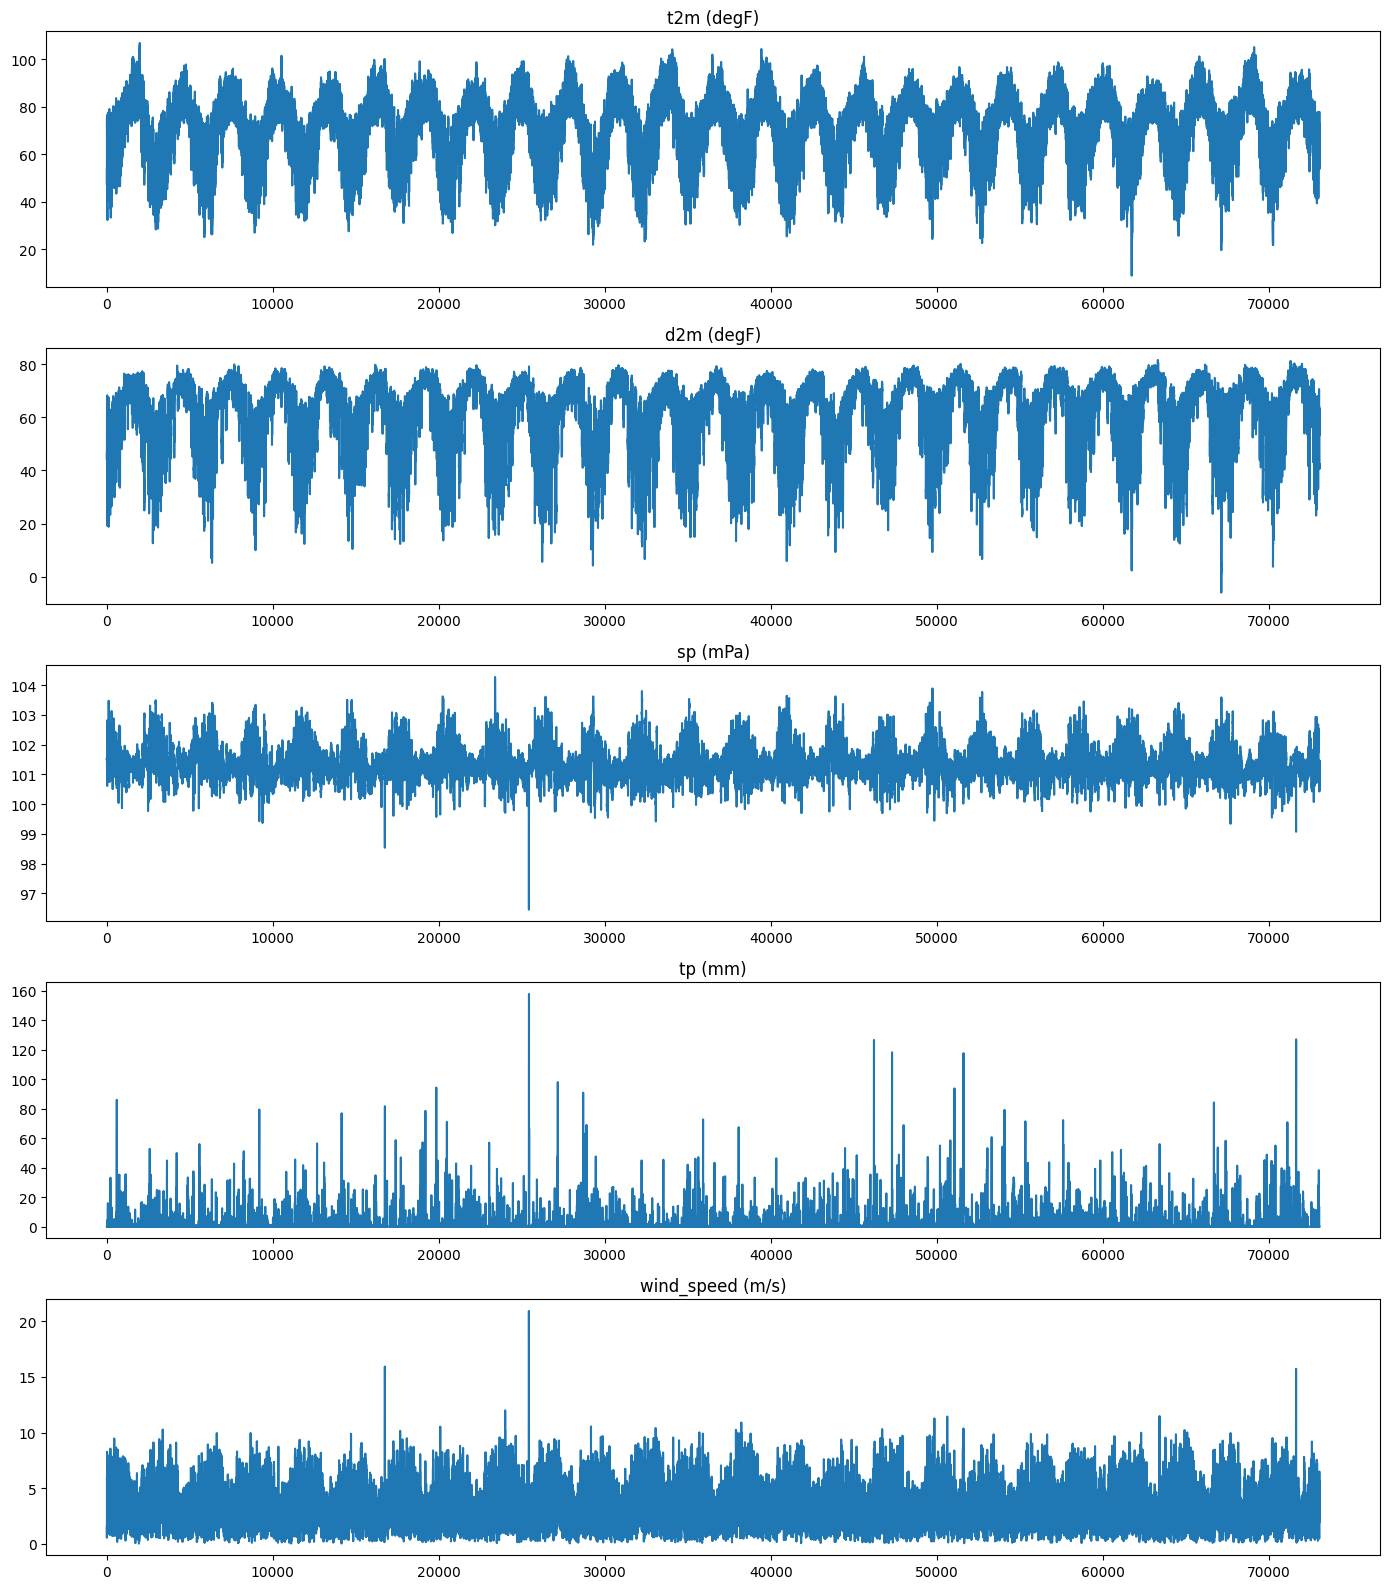

In [13]:
vars = ["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"]
fig = plt.figure(figsize=(14,16))
j = 1
for var in vars:
	array = np.array(clean_df[var]).reshape(clean_df.shape[0], 1)
	plt.subplot(5,1,j)
	plt.plot(array)
	plt.title(f"{var}")
	j += 1
plt.tight_layout()
plt.show()

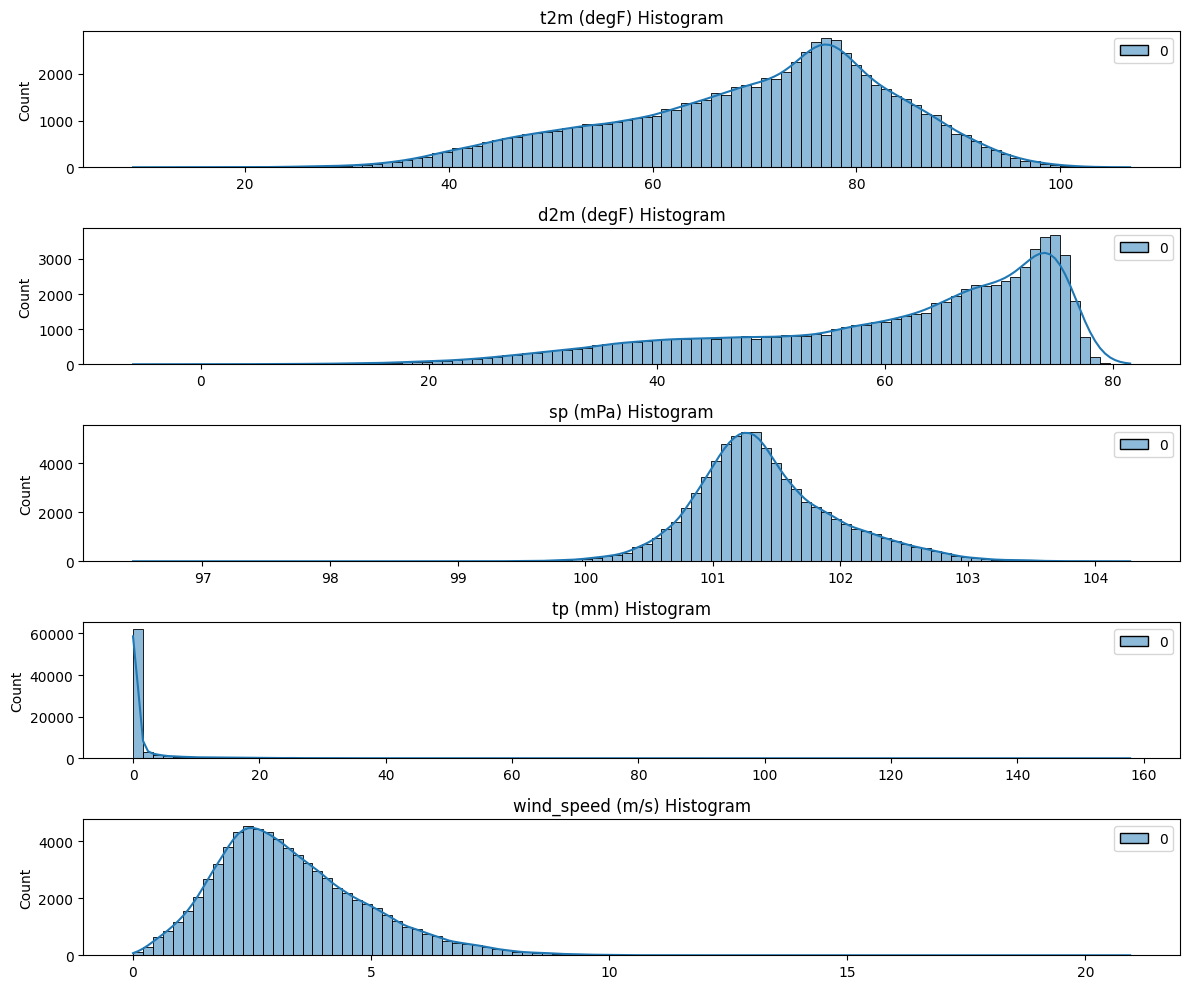

In [14]:
vars = ["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"]
fig = plt.figure(figsize=(12,10))
j = 1
for var in vars:
	array = np.array(clean_df[var]).reshape(clean_df.shape[0], 1)
	plt.subplot(5,1,j)
	sns.histplot(array, bins = 100, kde = True)
	plt.title(f"{var} Histogram")
	j += 1
plt.tight_layout()
plt.show()

Try to mitigate skewness of the distributions to make them more Gaussian

In [15]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

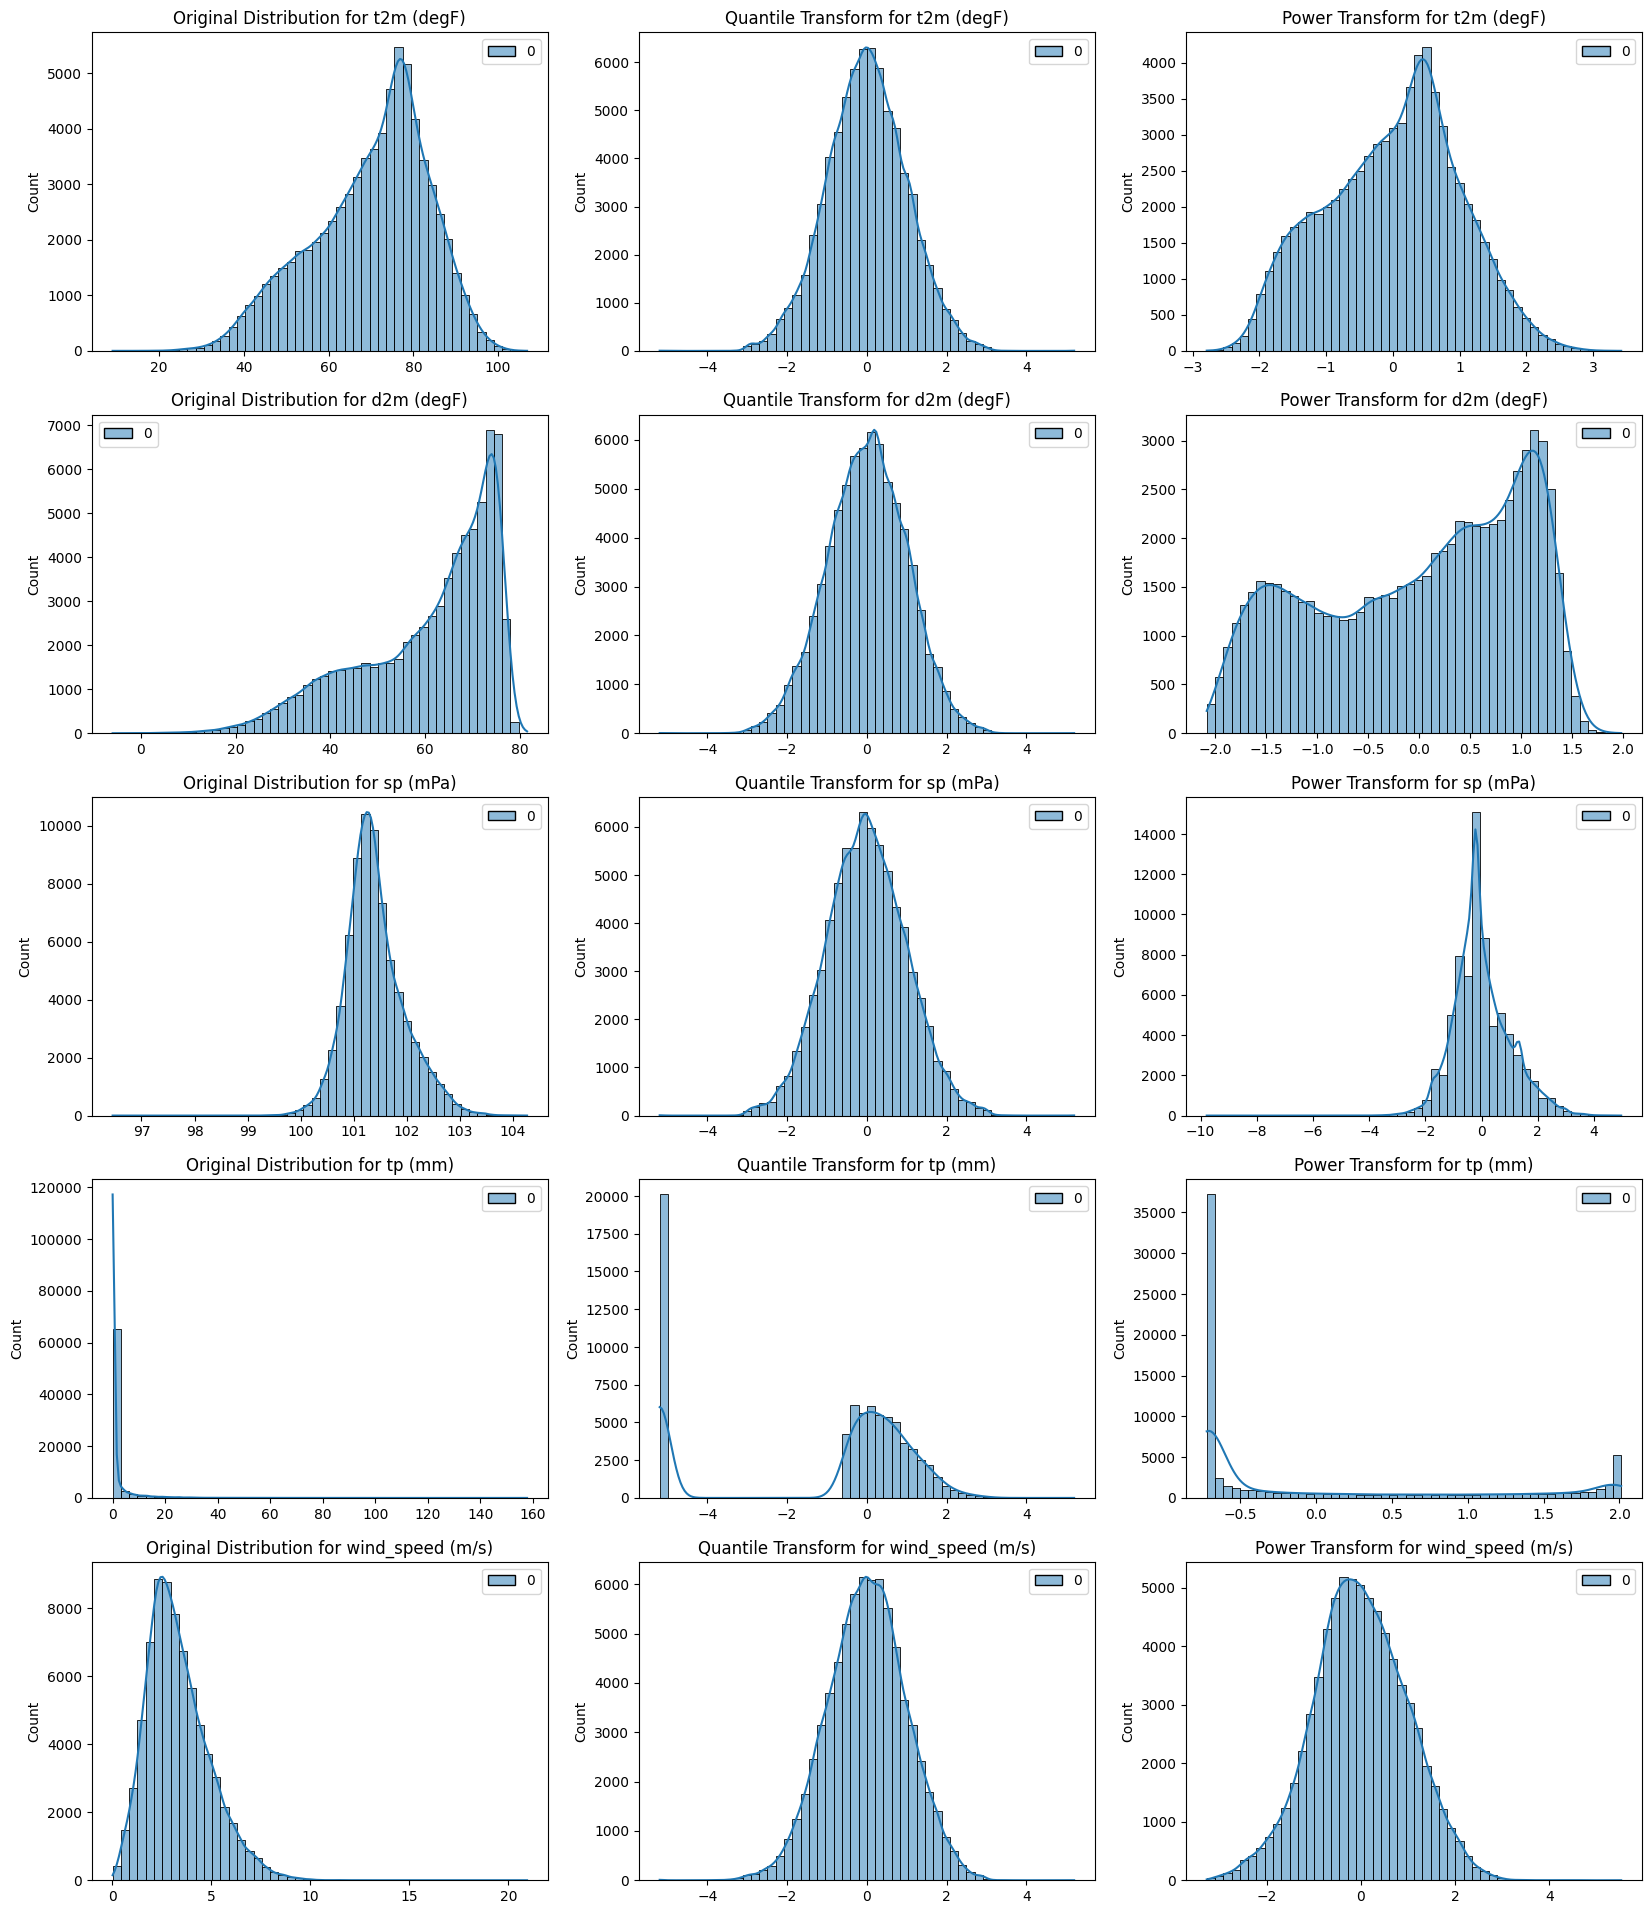

In [16]:
cols1 = ["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"]
def test_transformers(columns):
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    fig = plt.figure(figsize=(20,24))
    j = 1
    for i in columns:
        array = np.array(clean_df[i]).reshape(clean_df.shape[0], 1)
        y = pt.fit_transform(array)
        x = qt.fit_transform(array)
        plt.subplot(5,3,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Original Distribution for {i}")
        plt.subplot(5,3,j+1)
        sns.histplot(x, bins = 50, kde = True)
        plt.title(f"Quantile Transform for {i}")
        plt.subplot(5,3,j+2)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Power Transform for {i}")
        j += 3
test_transformers(cols1)
plt.show()

## Feature Engineering

### Supervised Learning and Time Series Forecasting

In [17]:
# Split data into train:val:test = 8:1:1
train_len = int(np.ceil(clean_df.shape[0]) * 0.8)
val_len = int(np.ceil(clean_df.shape[0]) * 0.9)

train_len, val_len

(58444, 65749)

In [18]:
# create train and test sets
train_df, val_df, test_df = clean_df[:train_len], clean_df[train_len:val_len], clean_df[val_len:]
train_df.shape, val_df.shape, test_df.shape

((58444, 5), (7305, 5), (7306, 5))

In [19]:
train_df.head()

t2m (degF)  d2m (degF)    sp (mPa)  tp (mm)  \
timestep                                                           
2000-01-01 03:00:00   53.574455   46.315296  101.505013      0.0   
2000-01-01 06:00:00   52.682693   45.413155  101.546806      0.0   
2000-01-01 09:00:00   47.315327   44.095562  101.490173      0.0   
2000-01-01 12:00:00   49.771866   45.025227  101.476913      0.0   
2000-01-01 15:00:00   55.661419   50.056526  101.570976      0.0   

                     wind_speed (m/s)  
timestep                               
2000-01-01 03:00:00          1.545924  
2000-01-01 06:00:00          0.538541  
2000-01-01 09:00:00          1.548828  
2000-01-01 12:00:00          1.020904  
2000-01-01 15:00:00          1.777430

In [20]:
val_df.head()

t2m (degF)  d2m (degF)    sp (mPa)   tp (mm)  \
timestep                                                            
2020-01-01 15:00:00   53.652901   37.926411  101.594742  0.000000   
2020-01-01 18:00:00   58.036224   43.382660  101.458832  0.000435   
2020-01-01 21:00:00   59.012909   48.065033  100.979195  0.001290   
2020-01-02 00:00:00   59.124584   53.914482  100.881157  0.180268   
2020-01-02 03:00:00   60.767151   59.281853  100.751396  1.553088   

                     wind_speed (m/s)  
timestep                               
2020-01-01 15:00:00          2.016809  
2020-01-01 18:00:00          3.311366  
2020-01-01 21:00:00          3.289088  
2020-01-02 00:00:00          3.601445  
2020-01-02 03:00:00          4.316188

In [21]:
test_df.head()

t2m (degF)  d2m (degF)    sp (mPa)   tp (mm)  \
timestep                                                            
2022-07-02 18:00:00   88.946701   75.194122  101.169518  1.561612   
2022-07-02 21:00:00   87.422119   74.823227  101.057770  5.261093   
2022-07-03 00:00:00   85.623497   74.397667  101.023895  5.508363   
2022-07-03 03:00:00   81.857498   76.136253  101.121498  0.000000   
2022-07-03 06:00:00   79.899124   76.345428  101.273445  0.000000   

                     wind_speed (m/s)  
timestep                               
2022-07-02 18:00:00          2.662505  
2022-07-02 21:00:00          4.439522  
2022-07-03 00:00:00          4.082767  
2022-07-03 03:00:00          3.719987  
2022-07-03 06:00:00          3.031985

In [22]:
train_std = train_df.std()
train_mean = train_df.mean()

scaled_train_df = (train_df - train_mean) / train_std
scaled_val_df = (val_df - train_mean) / train_std
scaled_test_df = (test_df - train_mean) / train_std

In [23]:
scaled_train_df.head()

t2m (degF)  d2m (degF)  sp (mPa)   tp (mm)  \
timestep                                                          
2000-01-01 03:00:00   -1.174859   -0.961216  0.160975 -0.268673   
2000-01-01 06:00:00   -1.239752   -1.023978  0.236106 -0.268673   
2000-01-01 09:00:00   -1.630333   -1.115644  0.134299 -0.268673   
2000-01-01 12:00:00   -1.451572   -1.050966  0.110462 -0.268673   
2000-01-01 15:00:00   -1.022992   -0.700937  0.279556 -0.268673   

                     wind_speed (m/s)  
timestep                               
2000-01-01 03:00:00         -1.123600  
2000-01-01 06:00:00         -1.759939  
2000-01-01 09:00:00         -1.121766  
2000-01-01 12:00:00         -1.455242  
2000-01-01 15:00:00         -0.977364

In [24]:
scaled_val_df.head()

t2m (degF)  d2m (degF)  sp (mPa)   tp (mm)  \
timestep                                                          
2020-01-01 15:00:00   -1.169151   -1.544834  0.322279 -0.268673   
2020-01-01 18:00:00   -0.850178   -1.165240  0.077957 -0.268598   
2020-01-01 21:00:00   -0.779106   -0.839486 -0.784274 -0.268451   
2020-01-02 00:00:00   -0.770979   -0.432537 -0.960513 -0.237733   
2020-01-02 03:00:00   -0.651450   -0.059127 -1.193781 -0.002114   

                     wind_speed (m/s)  
timestep                               
2020-01-01 15:00:00         -0.826155  
2020-01-01 18:00:00         -0.008416  
2020-01-01 21:00:00         -0.022488  
2020-01-02 00:00:00          0.174820  
2020-01-02 03:00:00          0.626304

In [25]:
scaled_test_df.head()

t2m (degF)  d2m (degF)  sp (mPa)   tp (mm)  \
timestep                                                          
2022-07-02 18:00:00    1.399162    1.047896 -0.442135 -0.000651   
2022-07-02 21:00:00    1.288219    1.022093 -0.643021  0.634296   
2022-07-03 00:00:00    1.157334    0.992486 -0.703917  0.676735   
2022-07-03 03:00:00    0.883284    1.113441 -0.528459 -0.268673   
2022-07-03 06:00:00    0.740774    1.127993 -0.255308 -0.268673   

                     wind_speed (m/s)  
timestep                               
2022-07-02 18:00:00         -0.418285  
2022-07-02 21:00:00          0.704211  
2022-07-03 00:00:00          0.478858  
2022-07-03 03:00:00          0.249699  
2022-07-03 06:00:00         -0.184894

### Training, Validation, and Testing Sets

In [26]:
# Split data into train, val, and test data sets

# Use past four days to forecast the next hour
lag_time = 32 # 4 days * 8 timesteps per day
lead_time = 1
window = lag_time + lead_time
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for i in range(scaled_train_df.shape[0]-window):
    x_train.append(scaled_train_df[i:i+lag_time])
    y_train.append(scaled_train_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_val_df.shape[0]-window):
    x_val.append(scaled_val_df[i:i+lag_time])
    y_val.append(scaled_val_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_test_df.shape[0]-window):
    x_test.append(scaled_test_df[i:i+lag_time])
    y_test.append(scaled_test_df[i+lag_time:i+window]["t2m (degF)"])

In [27]:
# Convert data sets to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

# Transpose arrays to fit input shape to LSTM 
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(58411, 32, 5) (7272, 32, 5) (7273, 32, 5)
(58411, 1) (7272, 1) (7273, 1)


### Model Training

In [28]:
from keras.layers import Dense, Activation, Dropout, Input, LSTM

from sklearn.metrics import mean_squared_error

In [29]:
model = keras.Sequential()
# input_shape = (batch, timesteps, features)
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(32, dropout=0.1))
model.add(Dense(y_train.shape[1], activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
MAX_EPOCHS = 10

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

  model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanAbsoluteError()])

  history = model.fit(x_train, y_train, epochs=MAX_EPOCHS, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1, batch_size=32)
  return history

In [31]:
history = compile_and_fit(model, x_train, y_train, x_val, y_val, patience=3)

Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.2053 - mean_absolute_error: 0.3260 - val_loss: 0.0438 - val_mean_absolute_error: 0.1551
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0501 - mean_absolute_error: 0.1489 - val_loss: 0.0370 - val_mean_absolute_error: 0.1454
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0413 - mean_absolute_error: 0.1329 - val_loss: 0.0325 - val_mean_absolute_error: 0.1361
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0378 - mean_absolute_error: 0.1285 - val_loss: 0.0313 - val_mean_absolute_error: 0.1306
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0363 - mean_absolute_error: 0.1251 - val_loss: 0.0361 - val_mean_absolute_error: 0.1429
Epoch 6/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0360 - mean_absolute_error: 0.1236 - val_loss: 0.0282 - val_mean_absolute_error: 0.1247
Epoch 7/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0353 - mean_absol

In [32]:
val_performance = {}
test_performance = {}

val_performance['LSTM'] = model.evaluate(x_val, y_val, return_dict=True)
test_performance['LSTM'] = model.evaluate(x_test, y_test, verbose=0, return_dict=True)

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0291 - mean_absolute_error: 0.1289


In [33]:
y_hat = model.predict(x_test)
rmse = np.mean(((y_hat - y_test) ** 2))
print('rmse of test set: ', rmse)

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
rmse of test set:  0.026910014


In [34]:
descaled_y_hat = y_hat * train_std["t2m (degF)"] + train_mean["t2m (degF)"]
descaled_y_test = y_test * train_std["t2m (degF)"] + train_mean["t2m (degF)"]

In [35]:
descaled_y_hat_df = pd.DataFrame(descaled_y_hat, columns=["t2m (degF)"])
descaled_y_hat_df["timestep"] = test_df.index[window:]
descaled_y_test_df = pd.DataFrame(descaled_y_test, columns=["t2m (degF)"])
descaled_y_test_df["timestep"] = test_df.index[window:]

In [36]:
descaled_y_hat_df = descaled_y_hat_df.set_index("timestep")
descaled_y_hat_df.head()

t2m (degF)
timestep                       
2022-07-06 21:00:00   91.504135
2022-07-07 00:00:00   90.529831
2022-07-07 03:00:00   84.574265
2022-07-07 06:00:00   80.712082
2022-07-07 09:00:00   79.666054

In [37]:
descaled_y_test_df = descaled_y_test_df.set_index("timestep")
descaled_y_test_df.head()

t2m (degF)
timestep                       
2022-07-06 21:00:00   91.710083
2022-07-07 00:00:00   89.560944
2022-07-07 03:00:00   86.825348
2022-07-07 06:00:00   82.892021
2022-07-07 09:00:00   80.645981

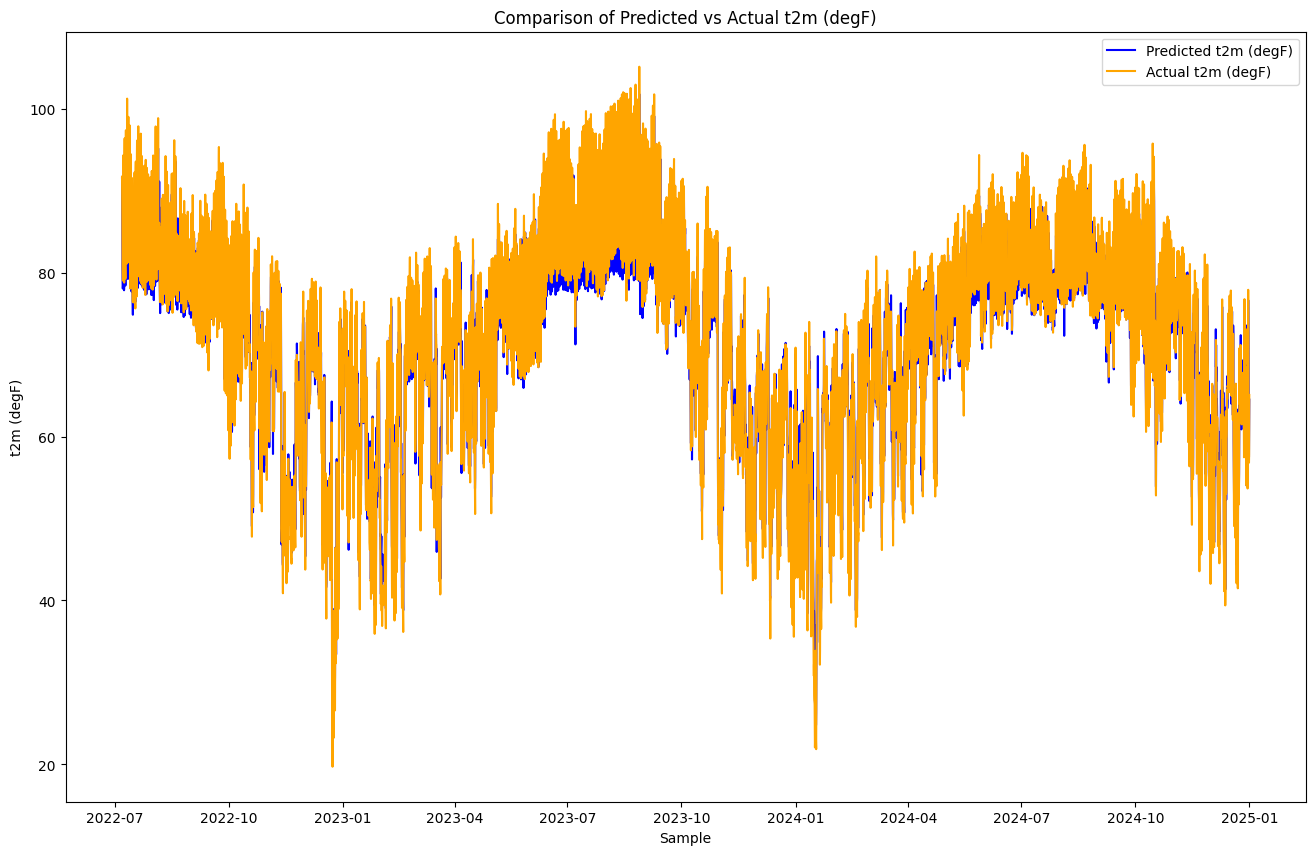

In [38]:
plt.figure(figsize=(16, 10))
plt.plot(test_df.index[window:], descaled_y_hat_df["t2m (degF)"], label='Predicted t2m (degF)', color='blue')
plt.plot(test_df.index[window:], descaled_y_test_df["t2m (degF)"], label='Actual t2m (degF)', color='orange')
plt.xlabel('Sample')
plt.ylabel('t2m (degF)')
plt.title('Comparison of Predicted vs Actual t2m (degF)')
plt.legend()
plt.show()


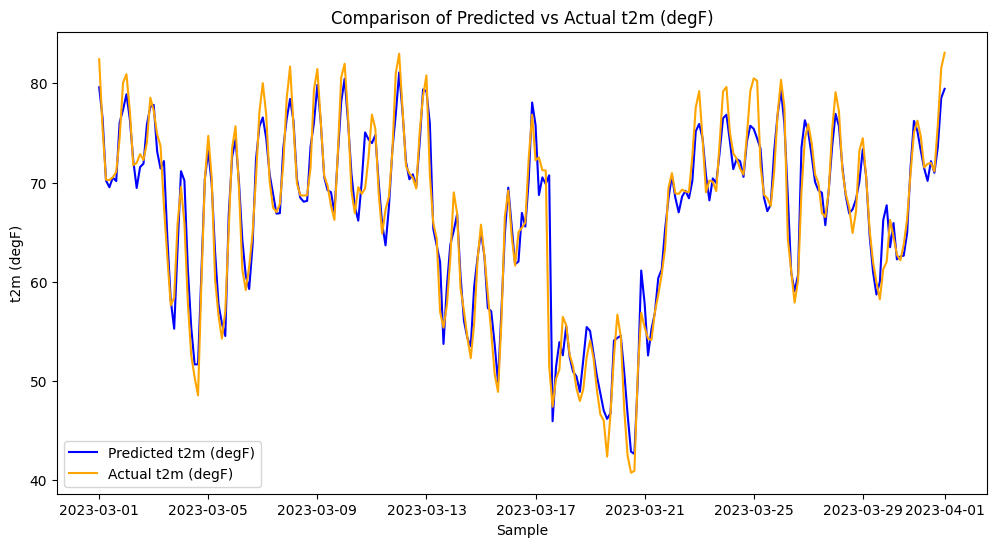

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(test_df["2023-03-01 00:00:00":"2023-04-01 00:00:00"].index, descaled_y_hat_df["t2m (degF)"]["2023-03-01 00:00:00":"2023-04-01 00:00:00"], label='Predicted t2m (degF)', color='blue')
plt.plot(test_df["2023-03-01 00:00:00":"2023-04-01 00:00:00"].index, descaled_y_test_df["t2m (degF)"]["2023-03-01 00:00:00":"2023-04-01 00:00:00"], label='Actual t2m (degF)', color='orange')
plt.xlabel('Sample')
plt.ylabel('t2m (degF)')
plt.title('Comparison of Predicted vs Actual t2m (degF)')
plt.legend()
plt.show()

## Outlier Removal Methods

#### Isolation Forest

In [40]:
from sklearn.ensemble import IsolationForest

In [41]:
iforest = IsolationForest(random_state=0, n_estimators = 100, contamination = 0.005, max_samples ='auto')
prediction = iforest.fit_predict(clean_df)

In [42]:
score = iforest.decision_function(clean_df)
clean_df["anomaly_score"] = score
clean_df['anomaly'] = prediction
clean_df.head()

t2m (degF)  d2m (degF)    sp (mPa)  tp (mm)  \
timestep                                                           
2000-01-01 03:00:00   53.574455   46.315296  101.505013      0.0   
2000-01-01 06:00:00   52.682693   45.413155  101.546806      0.0   
2000-01-01 09:00:00   47.315327   44.095562  101.490173      0.0   
2000-01-01 12:00:00   49.771866   45.025227  101.476913      0.0   
2000-01-01 15:00:00   55.661419   50.056526  101.570976      0.0   

                     wind_speed (m/s)  anomaly_score  anomaly  
timestep                                                       
2000-01-01 03:00:00          1.545924       0.220990        1  
2000-01-01 06:00:00          0.538541       0.169504        1  
2000-01-01 09:00:00          1.548828       0.208937        1  
2000-01-01 12:00:00          1.020904       0.193777        1  
2000-01-01 15:00:00          1.777430       0.234277        1

In [43]:
print("Number of outliers detected: {}".format(prediction[prediction < 0].sum()))
print("Number of normal samples detected: {}".format(prediction[prediction > 0].sum()))

Number of outliers detected: -366
Number of normal samples detected: 72689


In [44]:
outliers = clean_df[clean_df["anomaly"] < 0]
outliers.head()

t2m (degF)  d2m (degF)    sp (mPa)    tp (mm)  \
timestep                                                             
2000-03-15 12:00:00   60.967758   58.998955  100.694977  78.573959   
2000-03-15 21:00:00   69.484421   63.518898  100.539932  85.607246   
2000-03-16 00:00:00   67.354660   63.200512  100.586441  86.059708   
2000-10-08 15:00:00   53.627243   31.109173  102.905632  12.670714   
2000-10-08 18:00:00   52.120525   27.889191  102.957367  12.678826   

                     wind_speed (m/s)  anomaly_score  anomaly  
timestep                                                       
2000-03-15 12:00:00          5.436858      -0.009449       -1  
2000-03-15 21:00:00          2.095304      -0.003055       -1  
2000-03-16 00:00:00          1.195762      -0.001107       -1  
2000-10-08 15:00:00          6.689955      -0.020088       -1  
2000-10-08 18:00:00          6.263385      -0.015989       -1

In [45]:
outliers.describe()

t2m (degF)  d2m (degF)    sp (mPa)     tp (mm)  wind_speed (m/s)  \
count  366.000000  366.000000  366.000000  366.000000        366.000000   
mean    50.422588   38.996281  101.509735   31.026730          6.182724   
std     18.410532   23.314493    1.372938   33.483021          2.883276   
min     16.130196   -5.951584   96.455437    0.000000          0.554256   
25%     33.348997   18.285835  100.369305    3.044729          3.916918   
50%     49.862011   34.869354  101.369003   19.040209          6.422776   
75%     66.729008   60.945841  102.783598   45.569377          7.836652   
max     89.472946   78.168945  103.888481  157.861832         20.939119   

       anomaly_score  anomaly  
count     366.000000    366.0  
mean       -0.020919     -1.0  
std         0.017224      0.0  
min        -0.076546     -1.0  
25%        -0.029836     -1.0  
50%        -0.016413     -1.0  
75%        -0.007840     -1.0  
max        -0.000101     -1.0

In [46]:
clean_df.describe()

t2m (degF)    d2m (degF)      sp (mPa)       tp (mm)  \
count  73055.000000  73055.000000  73055.000000  73055.000000   
mean      69.931595     60.447334    101.408653      1.568756   
std       13.700654     14.353233      0.554503      5.766895   
min        8.998091     -5.951584     96.455437      0.000000   
25%       61.033569     51.129091    101.055138      0.000000   
50%       72.429192     65.077469    101.336639      0.007719   
75%       79.709282     72.252419    101.708073      0.441425   
max      106.855728     81.523239    104.272438    157.861832   

       wind_speed (m/s)  anomaly_score       anomaly  
count      73055.000000   73055.000000  73055.000000  
mean           3.324414       0.216212      0.989980  
std            1.586333       0.056709      0.141208  
min            0.006537      -0.076546     -1.000000  
25%            2.194770       0.192332      1.000000  
50%            3.069160       0.230909      1.000000  
75%            4.247519       0.257088      1.000000  
max           20.939119       0.291090      1.000000

<Axes: >

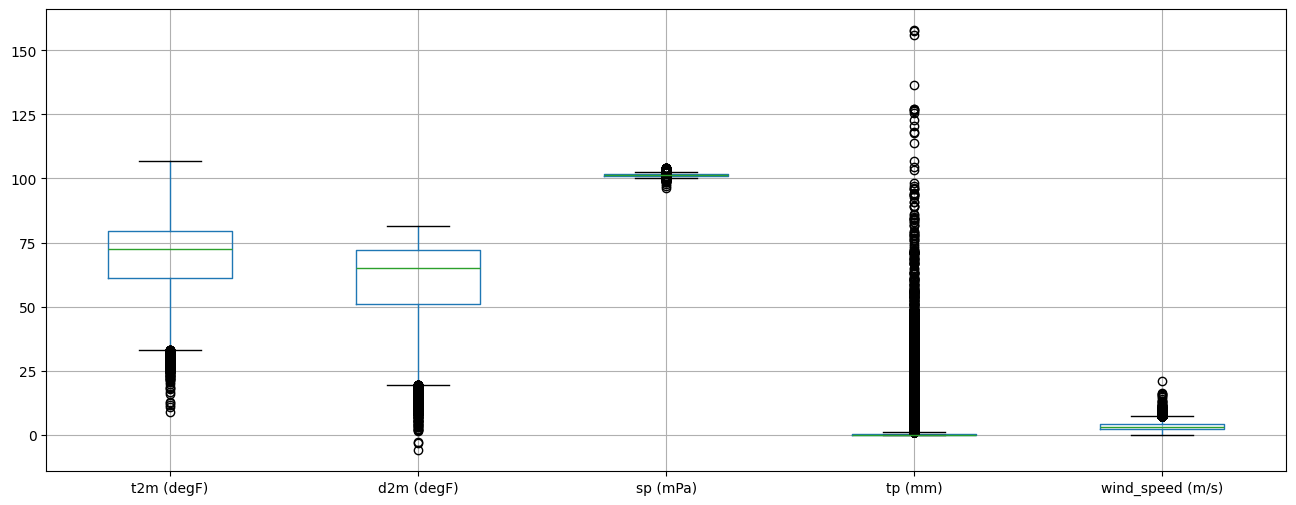

In [47]:
clean_df.boxplot(column=["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"], figsize=(16, 6))

<Axes: >

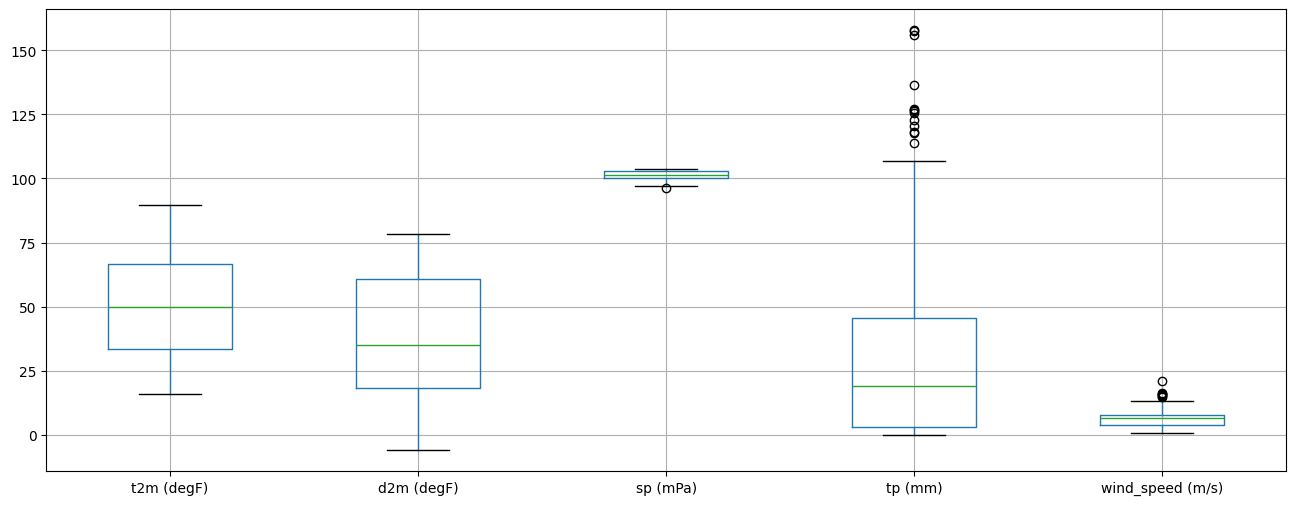

In [48]:
outliers.boxplot(column=["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"], figsize=(16, 6))

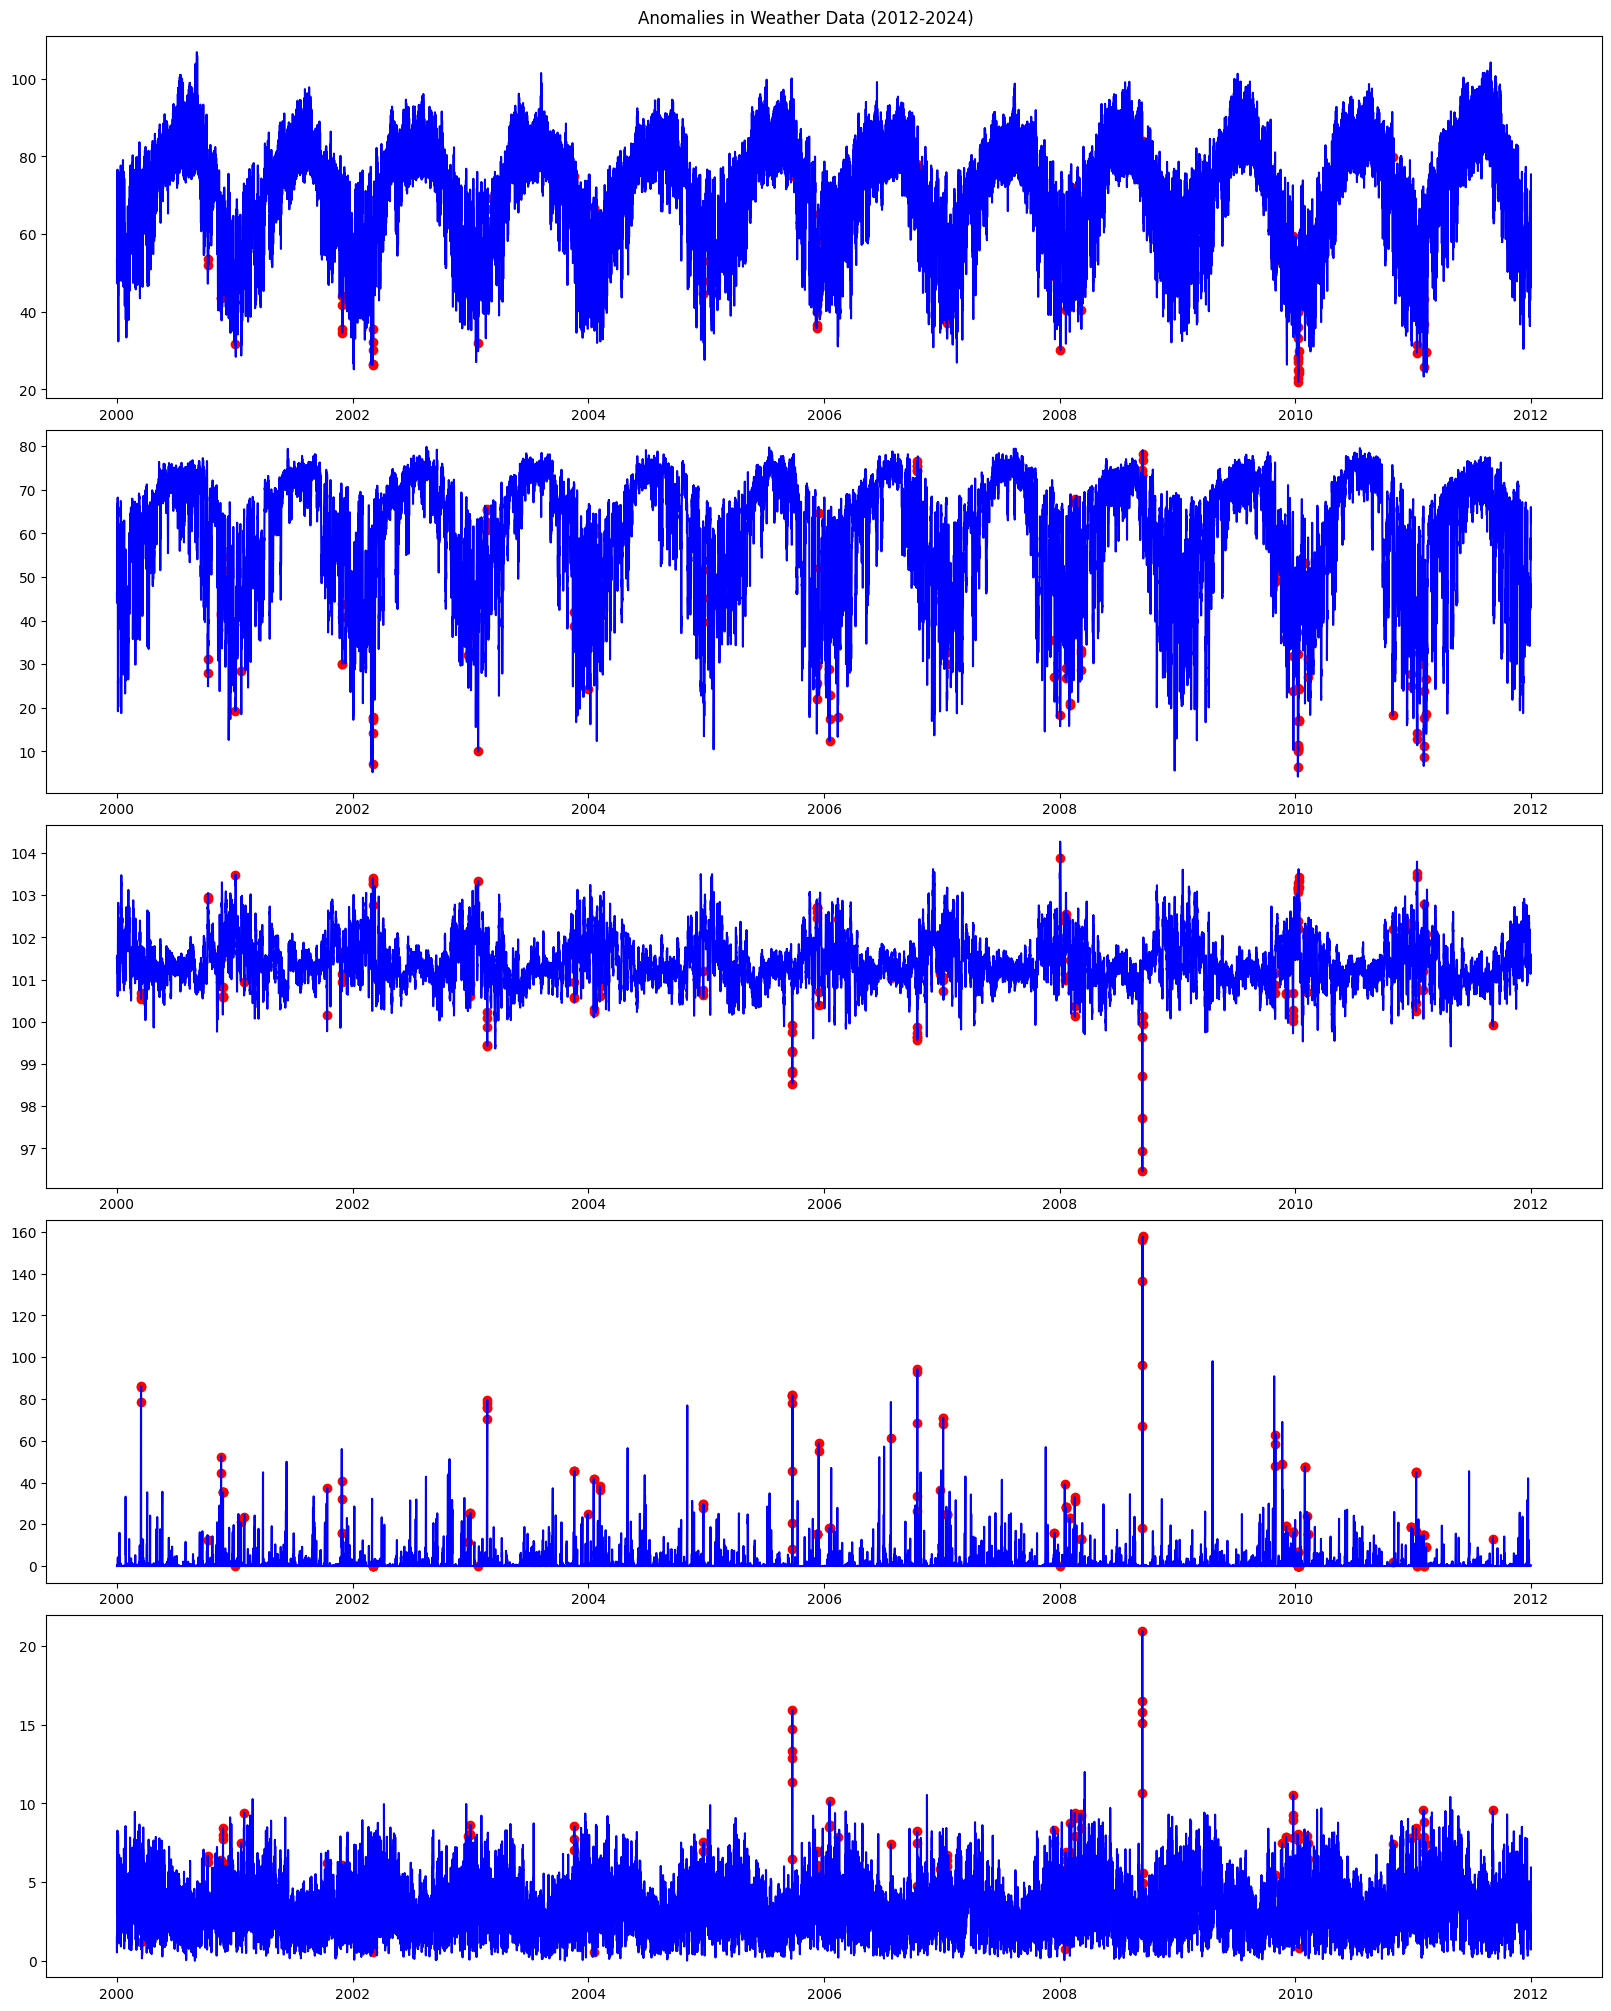

In [49]:
fig, axes = plt.subplots(5, 1, figsize=(16, 20), constrained_layout=True)
fig.suptitle("Anomalies in Weather Data (2012-2024)")
axes[0].plot(clean_df["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, clean_df["t2m (degF)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], label='t2m (degF)', color='blue')
axes[0].scatter(outliers["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, outliers["t2m (degF)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], color='red', label='Anomalies')
axes[1].plot(clean_df["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, clean_df["d2m (degF)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], label='d2m (degF)', color='blue')
axes[1].scatter(outliers["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, outliers["d2m (degF)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], color='red', label='Anomalies')
axes[2].plot(clean_df["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, clean_df["sp (mPa)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], label='sp (mPa)', color='blue')
axes[2].scatter(outliers["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, outliers["sp (mPa)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], color='red', label='Anomalies')
axes[3].plot(clean_df["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, clean_df["tp (mm)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], label='tp (mm)', color='blue')
axes[3].scatter(outliers["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, outliers["tp (mm)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], color='red', label='Anomalies')
axes[4].plot(clean_df["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, clean_df["wind_speed (m/s)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], label='wind_speed (m/s)', color='blue')
axes[4].scatter(outliers["2000-01-01 03:00:00":"2011-12-31 21:00:00"].index, outliers["wind_speed (m/s)"]["2000-01-01 03:00:00":"2011-12-31 21:00:00"], color='red', label='Anomalies')

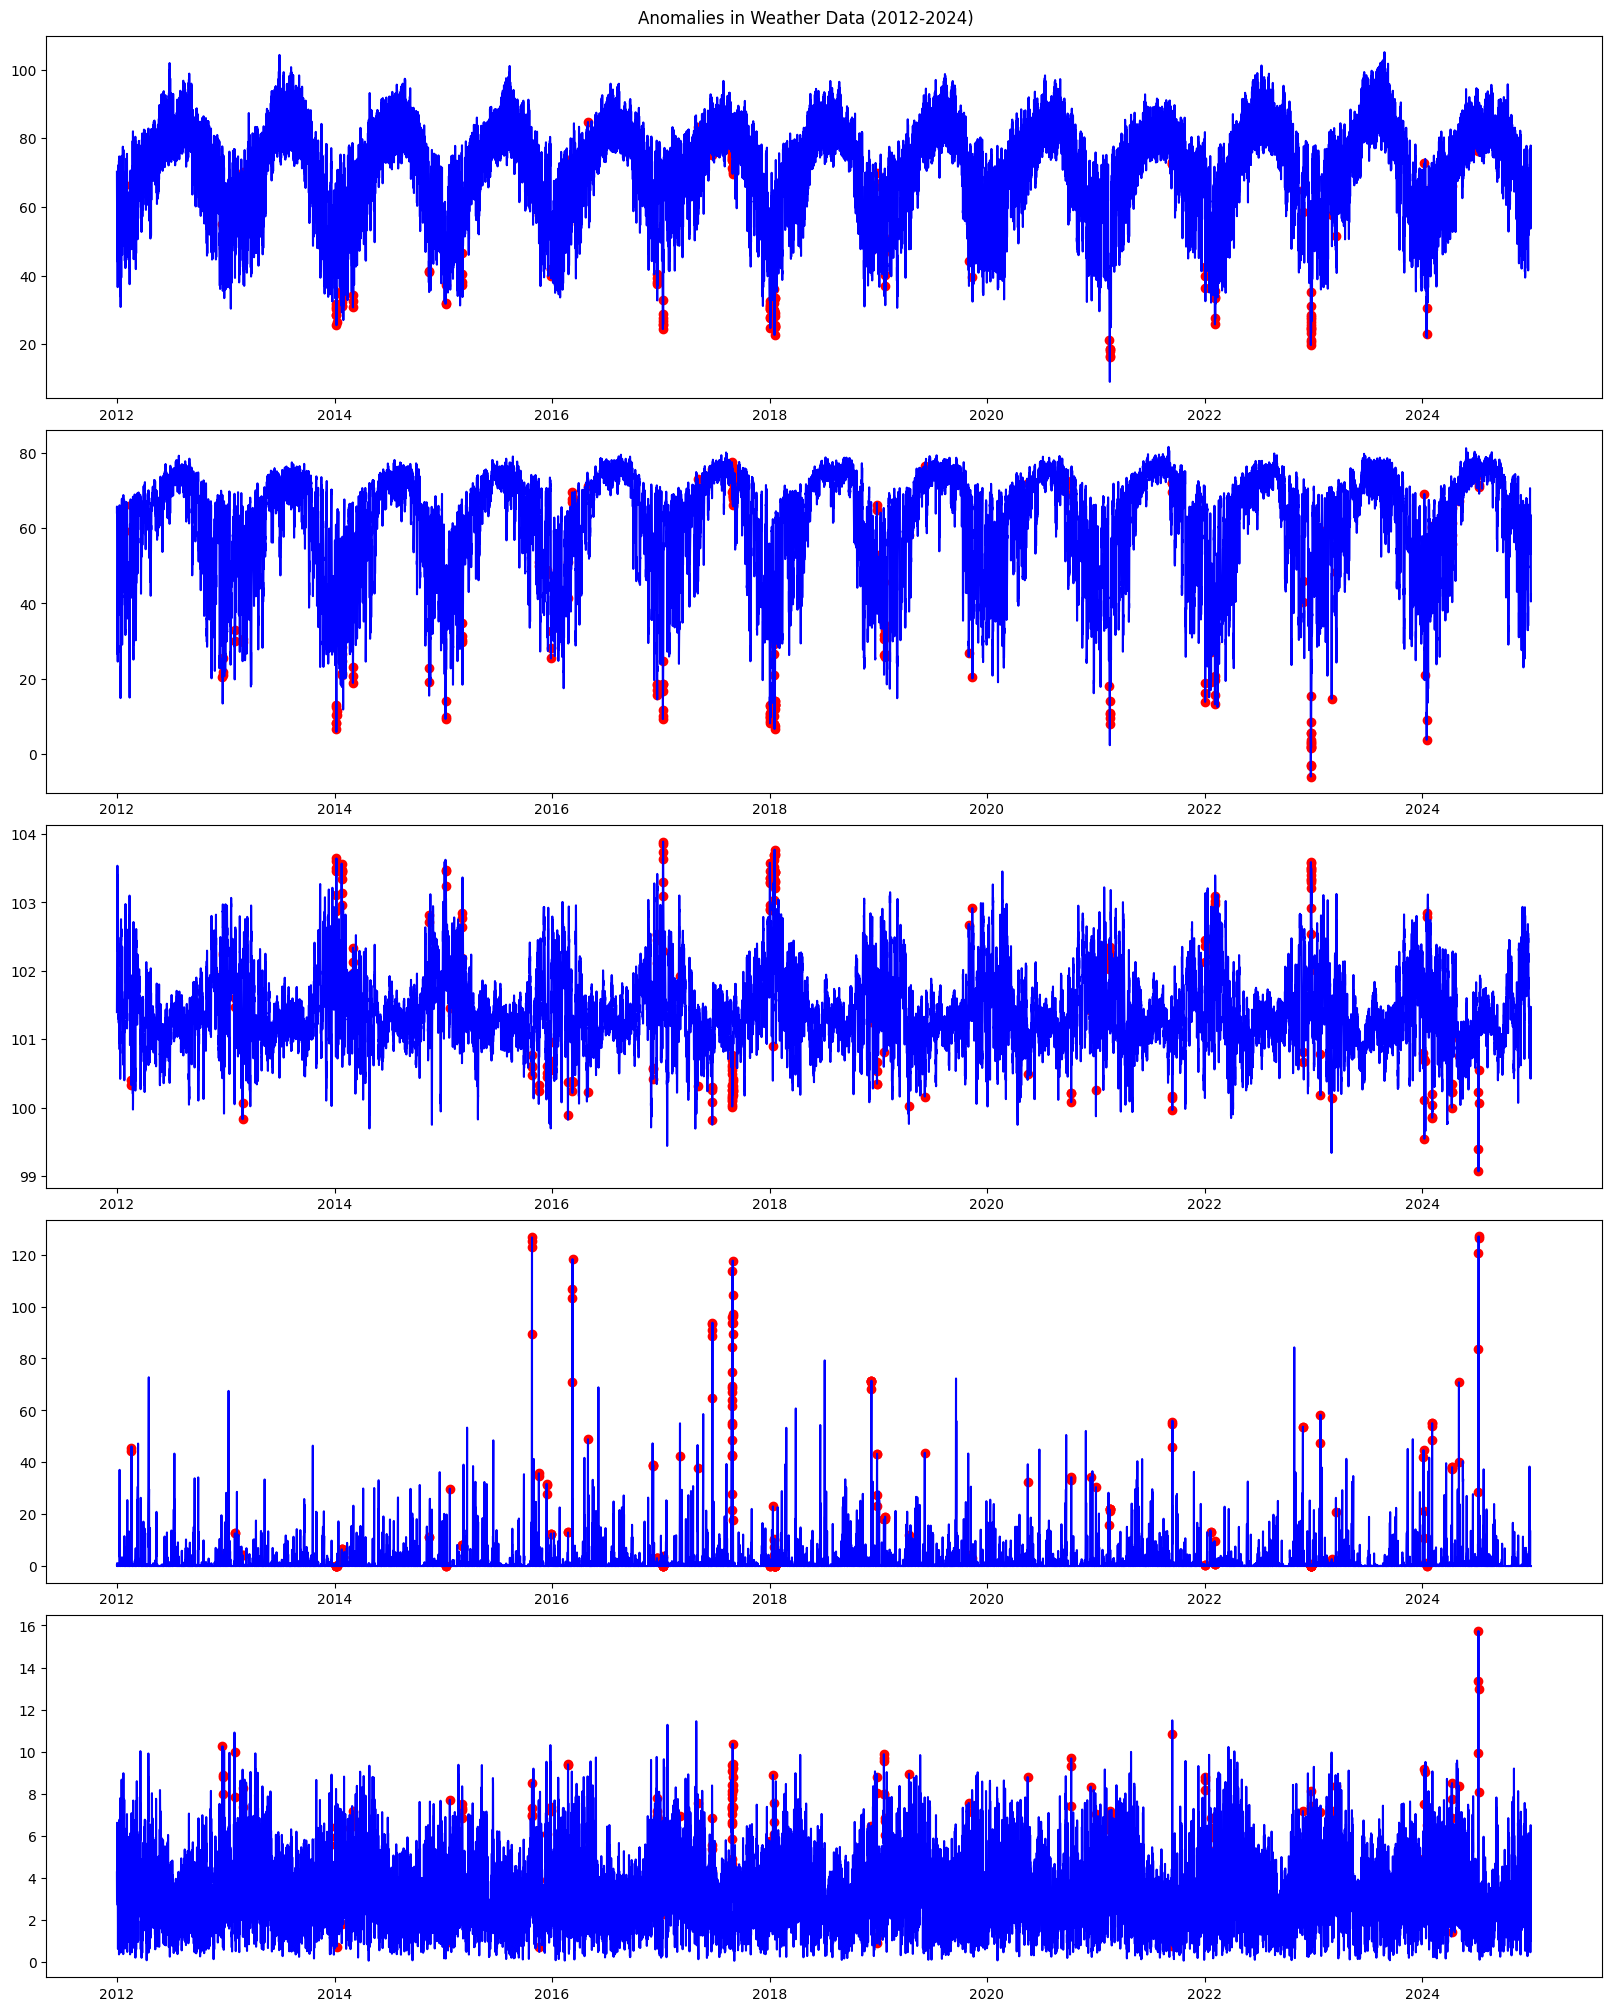

In [50]:
fig, axes = plt.subplots(5, 1, figsize=(16, 20), constrained_layout=True)
fig.suptitle("Anomalies in Weather Data (2012-2024)")
axes[0].plot(clean_df["2012-01-01":"2024-12-31"].index, clean_df["t2m (degF)"]["2012-01-01":"2024-12-31"], label='t2m (degF)', color='blue')
axes[0].scatter(outliers["2012-01-01":"2024-12-31"].index, outliers["t2m (degF)"]["2012-01-01":"2024-12-31"], color='red', label='Anomalies')
axes[1].plot(clean_df["2012-01-01":"2024-12-31"].index, clean_df["d2m (degF)"]["2012-01-01":"2024-12-31"], label='d2m (degF)', color='blue')
axes[1].scatter(outliers["2012-01-01":"2024-12-31"].index, outliers["d2m (degF)"]["2012-01-01":"2024-12-31"], color='red', label='Anomalies')
axes[2].plot(clean_df["2012-01-01":"2024-12-31"].index, clean_df["sp (mPa)"]["2012-01-01":"2024-12-31"], label='sp (mPa)', color='blue')
axes[2].scatter(outliers["2012-01-01":"2024-12-31"].index, outliers["sp (mPa)"]["2012-01-01":"2024-12-31"], color='red', label='Anomalies')
axes[3].plot(clean_df["2012-01-01":"2024-12-31"].index, clean_df["tp (mm)"]["2012-01-01":"2024-12-31"], label='tp (mm)', color='blue')
axes[3].scatter(outliers["2012-01-01":"2024-12-31"].index, outliers["tp (mm)"]["2012-01-01":"2024-12-31"], color='red', label='Anomalies')
axes[4].plot(clean_df["2012-01-01":"2024-12-31"].index, clean_df["wind_speed (m/s)"]["2012-01-01":"2024-12-31"], label='wind_speed (m/s)', color='blue')
axes[4].scatter(outliers["2012-01-01":"2024-12-31"].index, outliers["wind_speed (m/s)"]["2012-01-01":"2024-12-31"], color='red', label='Anomalies')

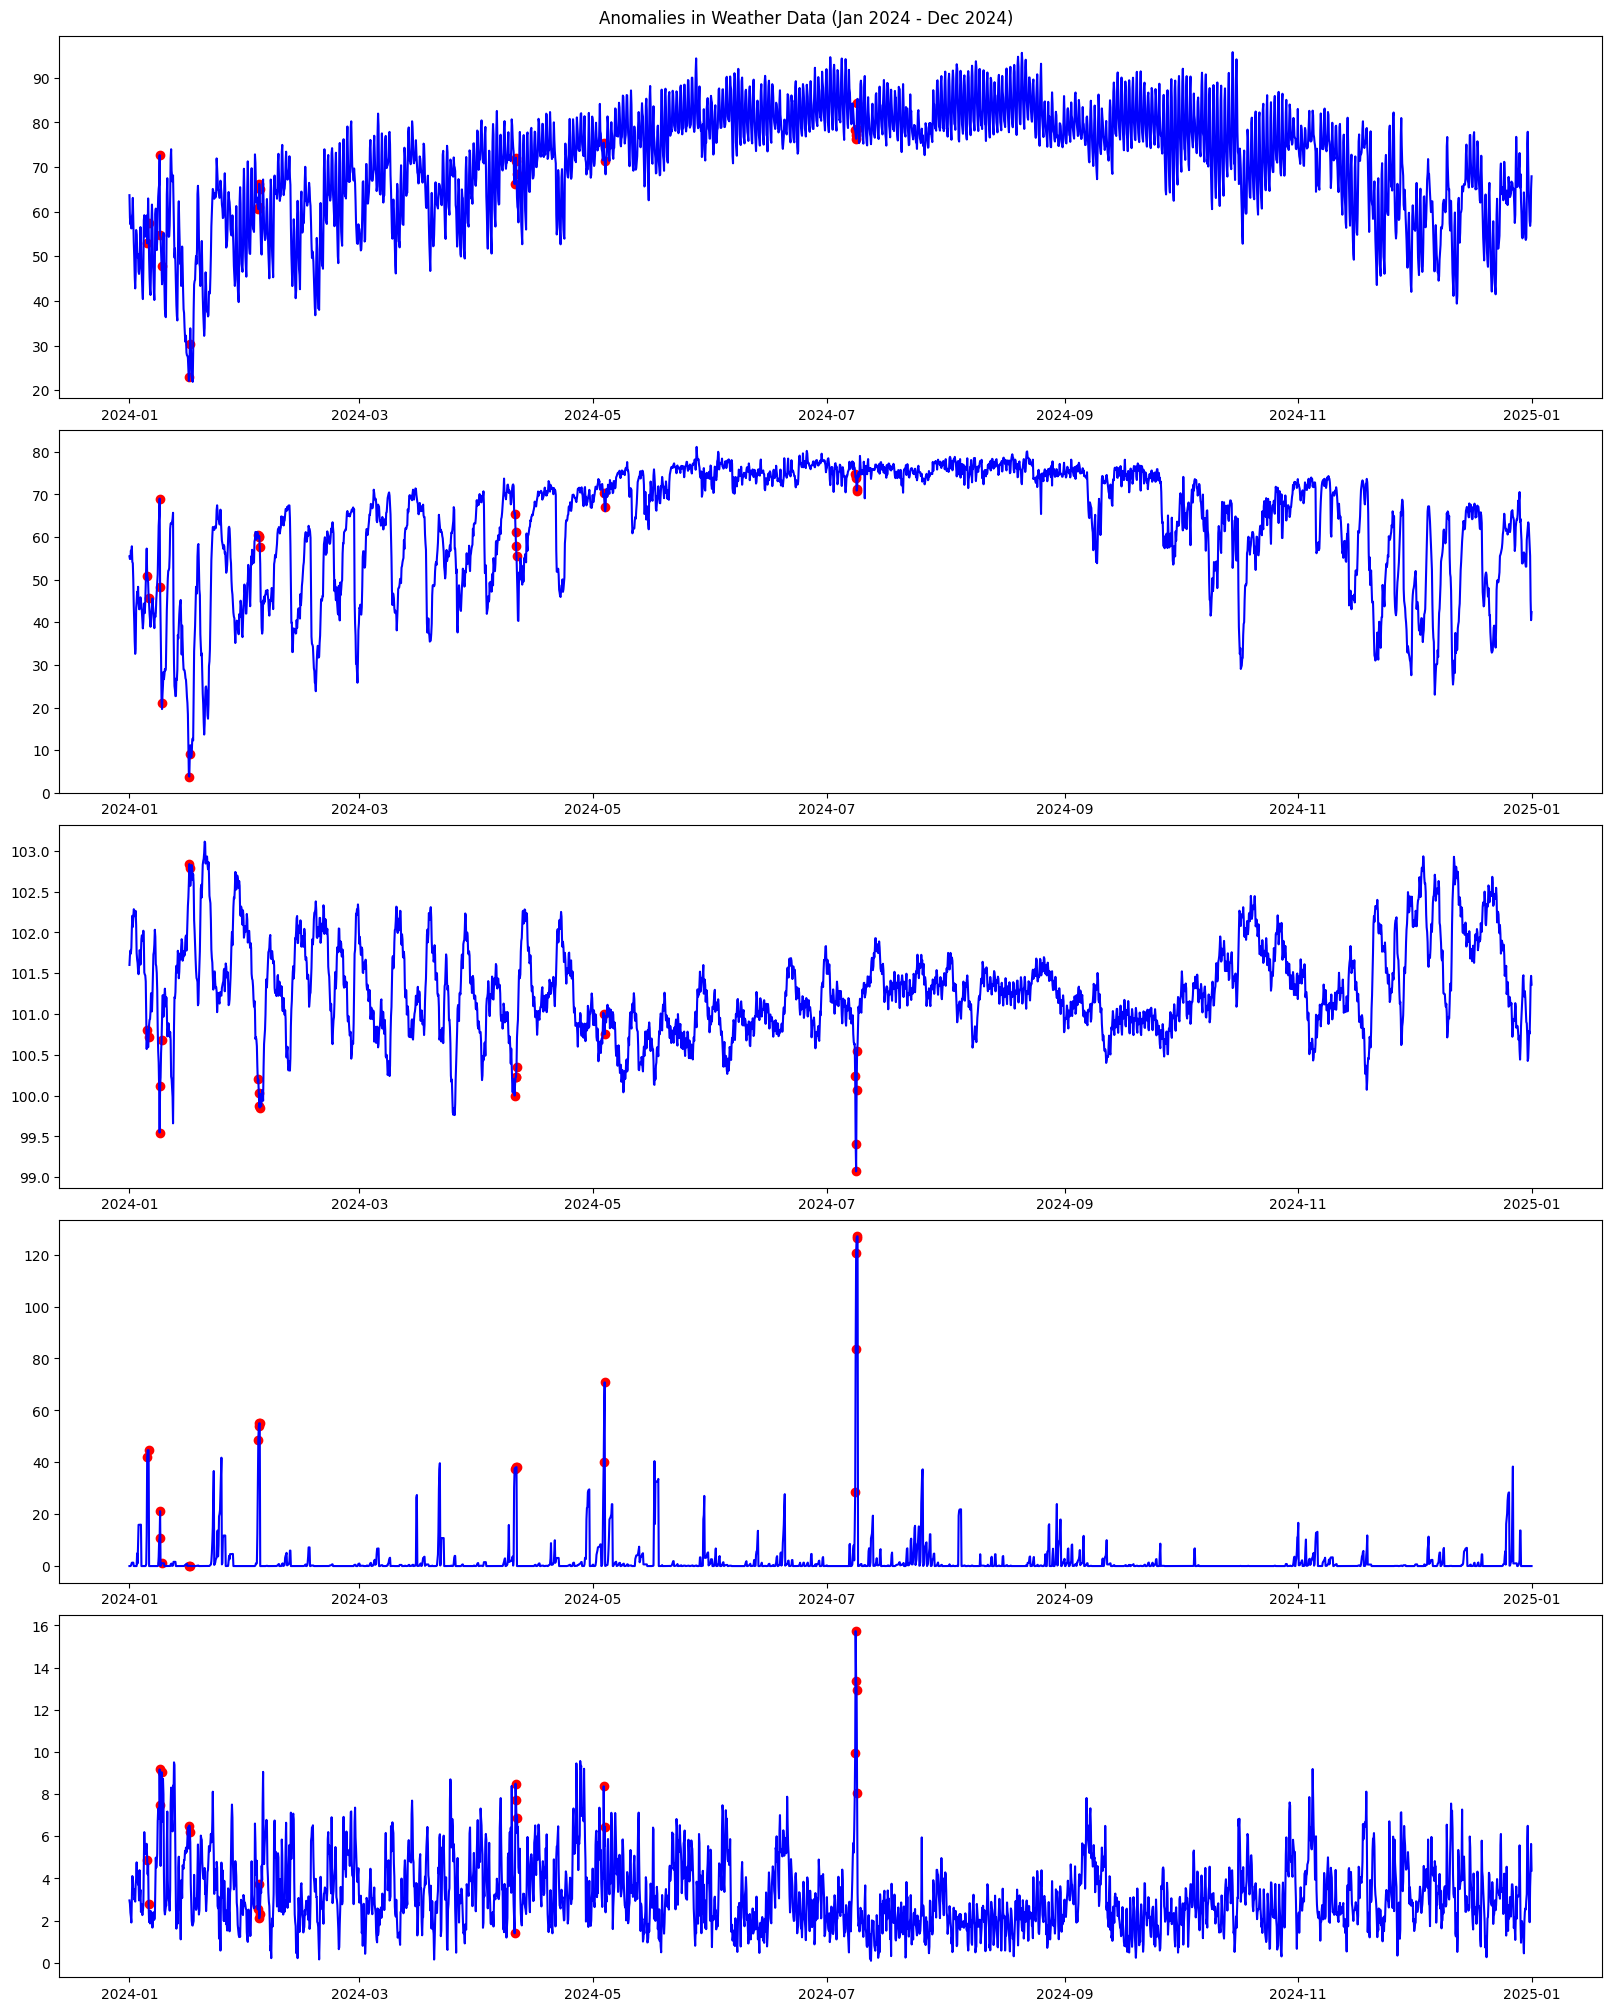

In [51]:
fig, axes = plt.subplots(5, 1, figsize=(16, 20), constrained_layout=True)
fig.suptitle("Anomalies in Weather Data (Jan 2024 - Dec 2024)")
axes[0].plot(clean_df["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, clean_df["t2m (degF)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], label='t2m (degF)', color='blue')
axes[0].scatter(outliers["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, outliers["t2m (degF)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], color='red', label='Anomalies')

axes[1].plot(clean_df["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, clean_df["d2m (degF)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], label='d2m (degF)', color='blue')
axes[1].scatter(outliers["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, outliers["d2m (degF)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], color='red', label='Anomalies')

axes[2].plot(clean_df["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, clean_df["sp (mPa)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], label='sp (mPa)', color='blue')
axes[2].scatter(outliers["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, outliers["sp (mPa)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], color='red', label='Anomalies')

axes[3].plot(clean_df["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, clean_df["tp (mm)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], label='tp (mm)', color='blue')
axes[3].scatter(outliers["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, outliers["tp (mm)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], color='red', label='Anomalies')

axes[4].plot(clean_df["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, clean_df["wind_speed (m/s)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], label='wind_speed (m/s)', color='blue')
axes[4].scatter(outliers["2024-01-01 00:00:00":"2024-12-31 21:00:00"].index, outliers["wind_speed (m/s)"]["2024-01-01 00:00:00":"2024-12-31 21:00:00"], color='red', label='Anomalies')

In [52]:
outliers.head()

t2m (degF)  d2m (degF)    sp (mPa)    tp (mm)  \
timestep                                                             
2000-03-15 12:00:00   60.967758   58.998955  100.694977  78.573959   
2000-03-15 21:00:00   69.484421   63.518898  100.539932  85.607246   
2000-03-16 00:00:00   67.354660   63.200512  100.586441  86.059708   
2000-10-08 15:00:00   53.627243   31.109173  102.905632  12.670714   
2000-10-08 18:00:00   52.120525   27.889191  102.957367  12.678826   

                     wind_speed (m/s)  anomaly_score  anomaly  
timestep                                                       
2000-03-15 12:00:00          5.436858      -0.009449       -1  
2000-03-15 21:00:00          2.095304      -0.003055       -1  
2000-03-16 00:00:00          1.195762      -0.001107       -1  
2000-10-08 15:00:00          6.689955      -0.020088       -1  
2000-10-08 18:00:00          6.263385      -0.015989       -1

In [53]:
reduced_outlier_df = clean_df.drop(["anomaly_score", "anomaly"], axis=1)

Taking advantage of the periodicity to impute the outlier with the mean of the past days temperatures. The window should be big enough for a reasonable average but small enough that it does not get affected by the trend.

In [54]:
for index, series in outliers.iterrows():
	last_3d_ranges = pd.date_range(start=pd.to_datetime(index) - pd.Timedelta(days=3, hours=3), end=pd.to_datetime(index) - pd.Timedelta(hours=3), freq='3h')
	reduced_outlier_df.loc[index, ["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"]] = clean_df.loc[last_3d_ranges, ["t2m (degF)", "d2m (degF)", "sp (mPa)", "tp (mm)", "wind_speed (m/s)"]].mean()

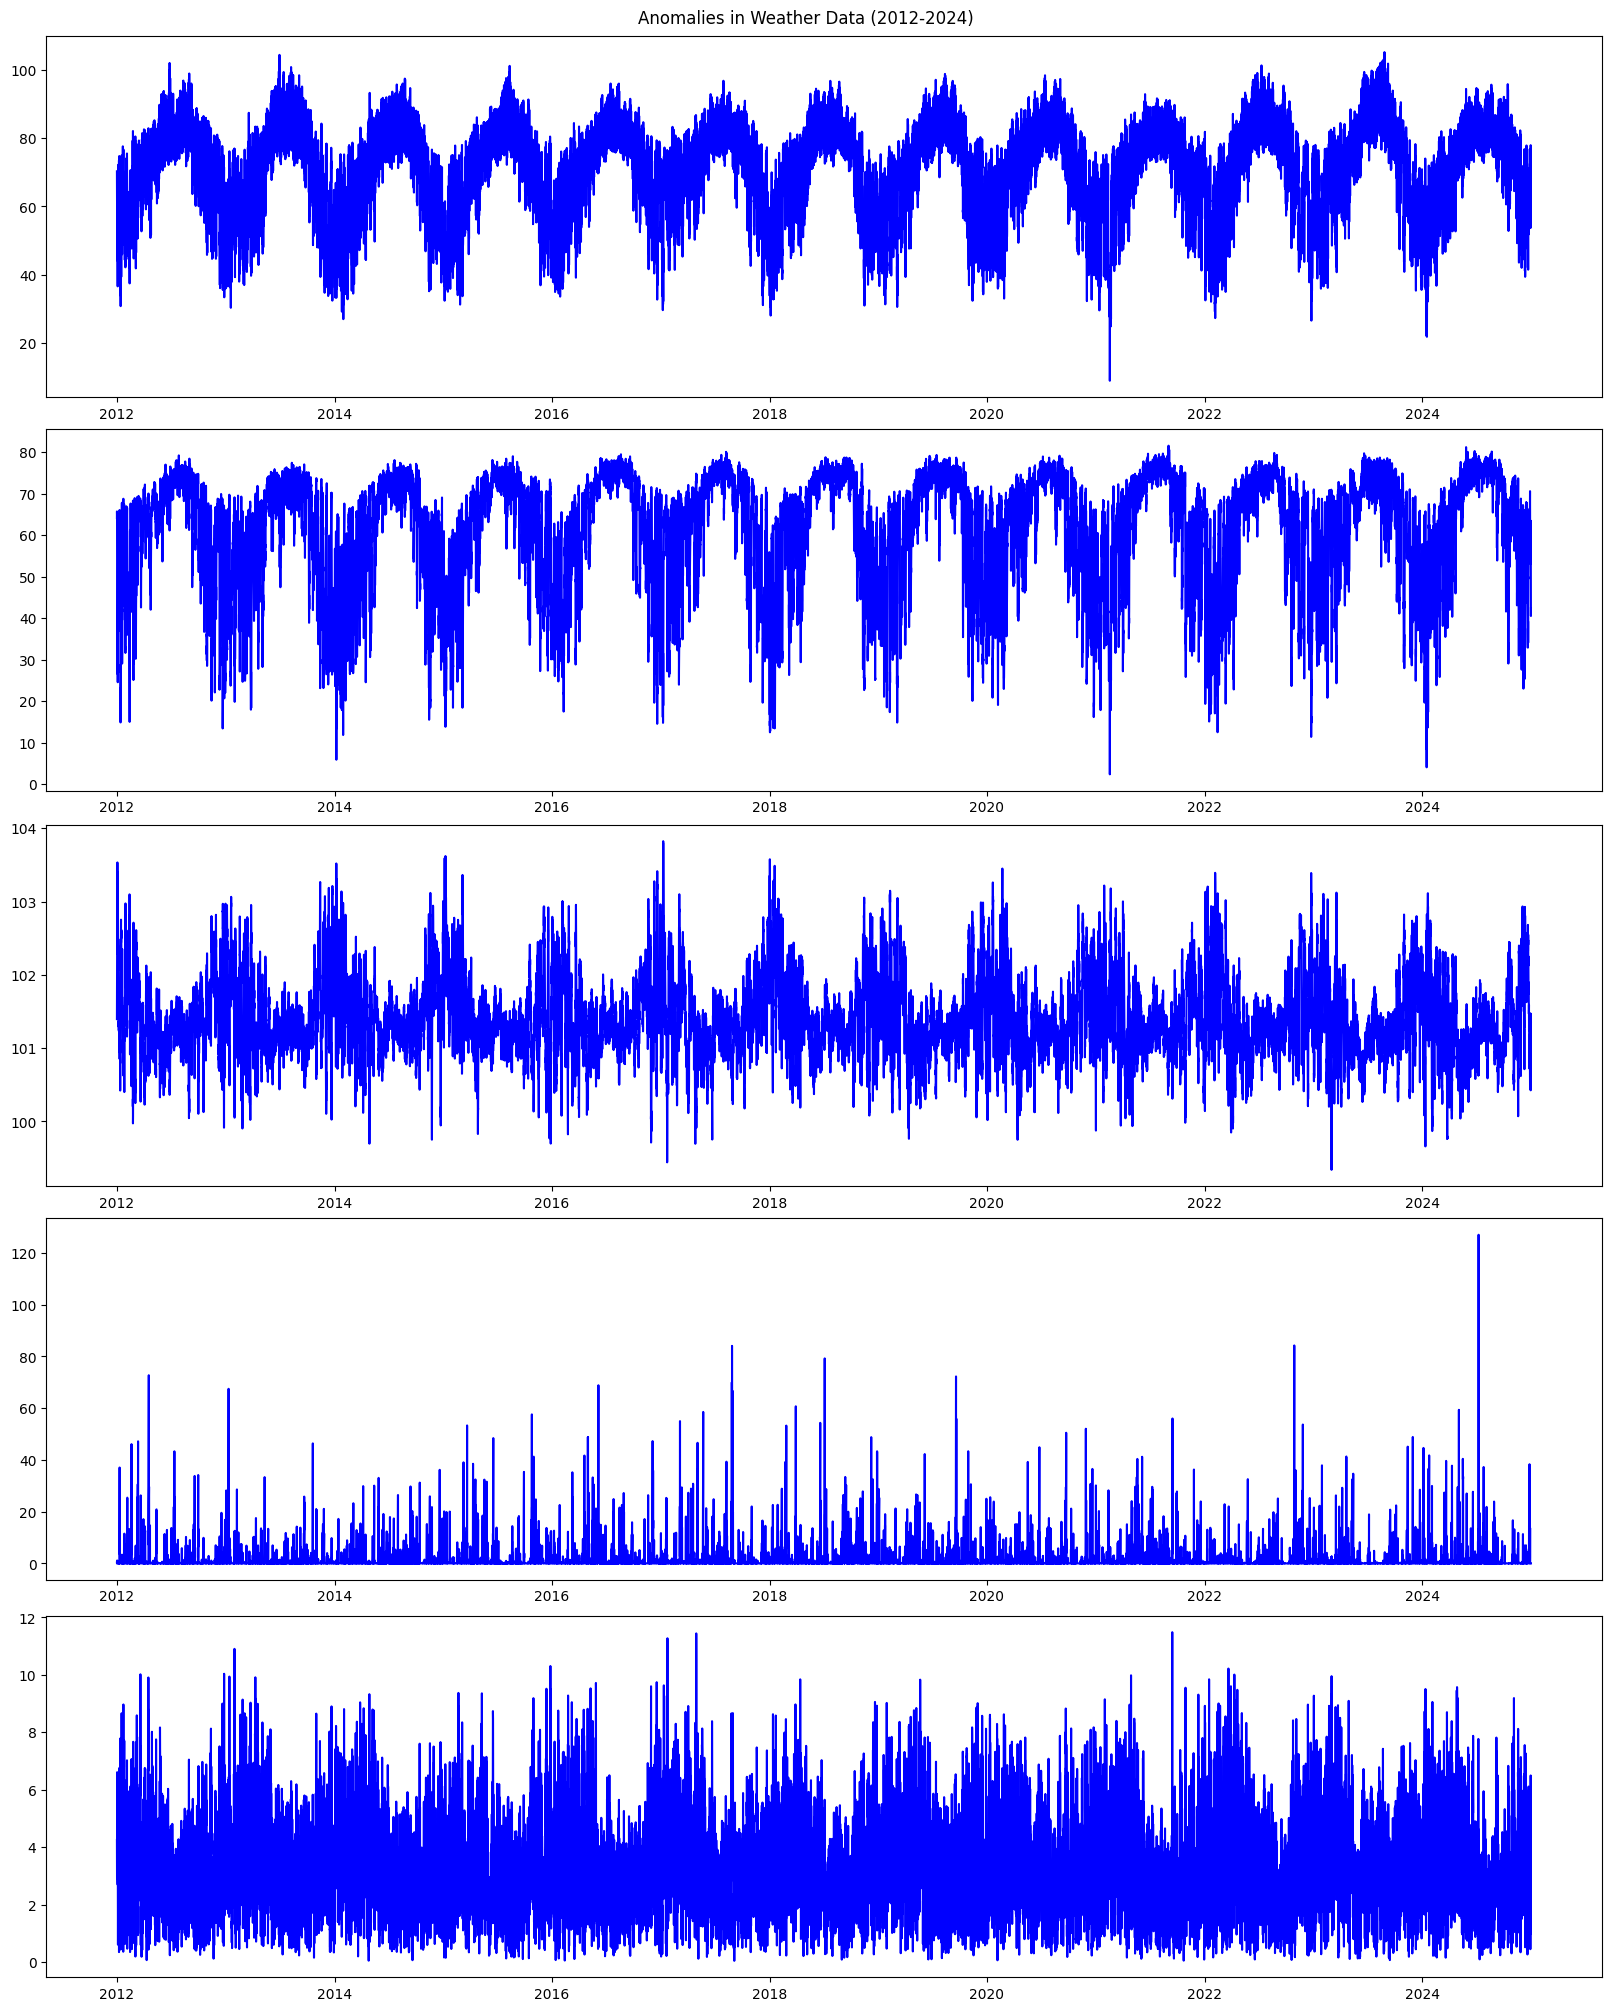

In [55]:
fig, axes = plt.subplots(5, 1, figsize=(16, 20), constrained_layout=True)
fig.suptitle("Anomalies in Weather Data (2012-2024)")
axes[0].plot(reduced_outlier_df["2012-01-01":"2024-12-31"].index, reduced_outlier_df["t2m (degF)"]["2012-01-01":"2024-12-31"], label='t2m (degF)', color='blue')
axes[1].plot(reduced_outlier_df["2012-01-01":"2024-12-31"].index, reduced_outlier_df["d2m (degF)"]["2012-01-01":"2024-12-31"], label='d2m (degF)', color='blue')
axes[2].plot(reduced_outlier_df["2012-01-01":"2024-12-31"].index, reduced_outlier_df["sp (mPa)"]["2012-01-01":"2024-12-31"], label='sp (mPa)', color='blue')
axes[3].plot(reduced_outlier_df["2012-01-01":"2024-12-31"].index, reduced_outlier_df["tp (mm)"]["2012-01-01":"2024-12-31"], label='tp (mm)', color='blue')
axes[4].plot(reduced_outlier_df["2012-01-01":"2024-12-31"].index, reduced_outlier_df["wind_speed (m/s)"]["2012-01-01":"2024-12-31"], label='wind_speed (m/s)', color='blue')

In [56]:
train_len = int(np.ceil(reduced_outlier_df.shape[0]) * 0.8)
val_len = int(np.ceil(reduced_outlier_df.shape[0]) * 0.9)

reduced_outlier_train_df, reduced_outlier_val_df, reduced_outlier_test_df = reduced_outlier_df[:train_len], reduced_outlier_df[train_len:val_len], reduced_outlier_df[val_len:]

reduced_outlier_train_std = reduced_outlier_train_df.std()
reduced_outlier_train_mean = reduced_outlier_train_df.mean()

scaled_reduced_outlier_train_df = (reduced_outlier_train_df - reduced_outlier_train_mean) / reduced_outlier_train_std
scaled_reduced_outlier_val_df = (reduced_outlier_val_df - reduced_outlier_train_mean) / reduced_outlier_train_std
scaled_reduced_outlier_test_df = (reduced_outlier_test_df - reduced_outlier_train_mean) / reduced_outlier_train_std

In [ ]:
lag_time = 32 # 4 days * 8 timesteps per day
lead_time = 1
window = lag_time + lead_time
reduced_outlier_x_train = []
reduced_outlier_y_train = []
reduced_outlier_x_val = []
reduced_outlier_y_val = []
reduced_outlier_x_test = []
reduced_outlier_y_test = []

for i in range(scaled_reduced_outlier_train_df.shape[0]-window):
    reduced_outlier_x_train.append(scaled_reduced_outlier_train_df[i:i+lag_time])
    reduced_outlier_y_train.append(scaled_reduced_outlier_train_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_reduced_outlier_val_df.shape[0]-window):
    reduced_outlier_x_val.append(scaled_reduced_outlier_val_df[i:i+lag_time])
    reduced_outlier_y_val.append(scaled_reduced_outlier_val_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_reduced_outlier_test_df.shape[0]-window):
    reduced_outlier_x_test.append(scaled_reduced_outlier_test_df[i:i+lag_time])
    reduced_outlier_y_test.append(scaled_reduced_outlier_test_df[i+lag_time:i+window]["t2m (degF)"])

reduced_outlier_x_train, reduced_outlier_y_train = np.array(reduced_outlier_x_train), np.array(reduced_outlier_y_train)
reduced_outlier_x_val, reduced_outlier_y_val = np.array(reduced_outlier_x_val), np.array(reduced_outlier_y_val)
reduced_outlier_x_test, reduced_outlier_y_test = np.array(reduced_outlier_x_test), np.array(reduced_outlier_y_test)

In [58]:
reduced_outlier_x_train.shape, reduced_outlier_y_train.shape

((58411, 32, 5), (58411, 1))

In [59]:
reduced_outlier_model = keras.Sequential()
reduced_outlier_model.add(Input(shape=(reduced_outlier_x_train.shape[1], reduced_outlier_x_train.shape[2])))
reduced_outlier_model.add(LSTM(32, dropout=0.1))
reduced_outlier_model.add(Dense(reduced_outlier_y_train.shape[1], activation='linear'))
reduced_outlier_model.summary()

history = compile_and_fit(reduced_outlier_model, reduced_outlier_x_train, reduced_outlier_y_train, reduced_outlier_x_val, reduced_outlier_y_val, patience=3)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.1986 - mean_absolute_error: 0.3385 - val_loss: 0.0503 - val_mean_absolute_error: 0.1677
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0667 - mean_absolute_error: 0.1759 - val_loss: 0.0383 - val_mean_absolute_error: 0.1438
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0511 - mean_absolute_error: 0.1503 - val_loss: 0.0356 - val_mean_absolute_error: 0.1349
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0444 - mean_absolute_error: 0.1368 - val_loss: 0.0365 - val_mean_absolute_error: 0.1416
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0398 - mean_absolute_error: 0.1302 - val_loss: 0.0349 - val_mean_absolute_error: 0.1363
Epoch 6/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0397 - mean_absolute_error: 0.1286 - val_loss: 0.0322 - val_mean_absolute_error: 0.1341
Epoch 7/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0371 - mean_absol

In [60]:
val_performance['Reduced Outlier LSTM'] = reduced_outlier_model.evaluate(reduced_outlier_x_val, reduced_outlier_y_val, return_dict=True)
test_performance['Reduced Outlier LSTM'] = reduced_outlier_model.evaluate(reduced_outlier_x_test, reduced_outlier_y_test, verbose=0, return_dict=True)

y_hat = reduced_outlier_model.predict(reduced_outlier_x_test)
rmse = np.mean(((y_hat - reduced_outlier_y_test) ** 2))

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0318 - mean_absolute_error: 0.1326
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [61]:
print("LSTM test performance", test_performance["LSTM"])
print("Reduced Outlier LSTM test performance", test_performance["Reduced Outlier LSTM"])

LSTM test performance {'loss': 0.02691001631319523, 'mean_absolute_error': 0.12596651911735535}
Reduced Outlier LSTM test performance {'loss': 0.029915185645222664, 'mean_absolute_error': 0.13129635155200958}


In [62]:
clean_df = reduced_outlier_df.copy()

## Seasonality and Trend

In [63]:
from statsmodels.tsa.seasonal import STL

In [71]:
stl = STL(clean_df['t2m (degF)'], period=2920)  # period set to 8*365 = 2920 for 3-hr timesteps across a year
result = stl.fit()

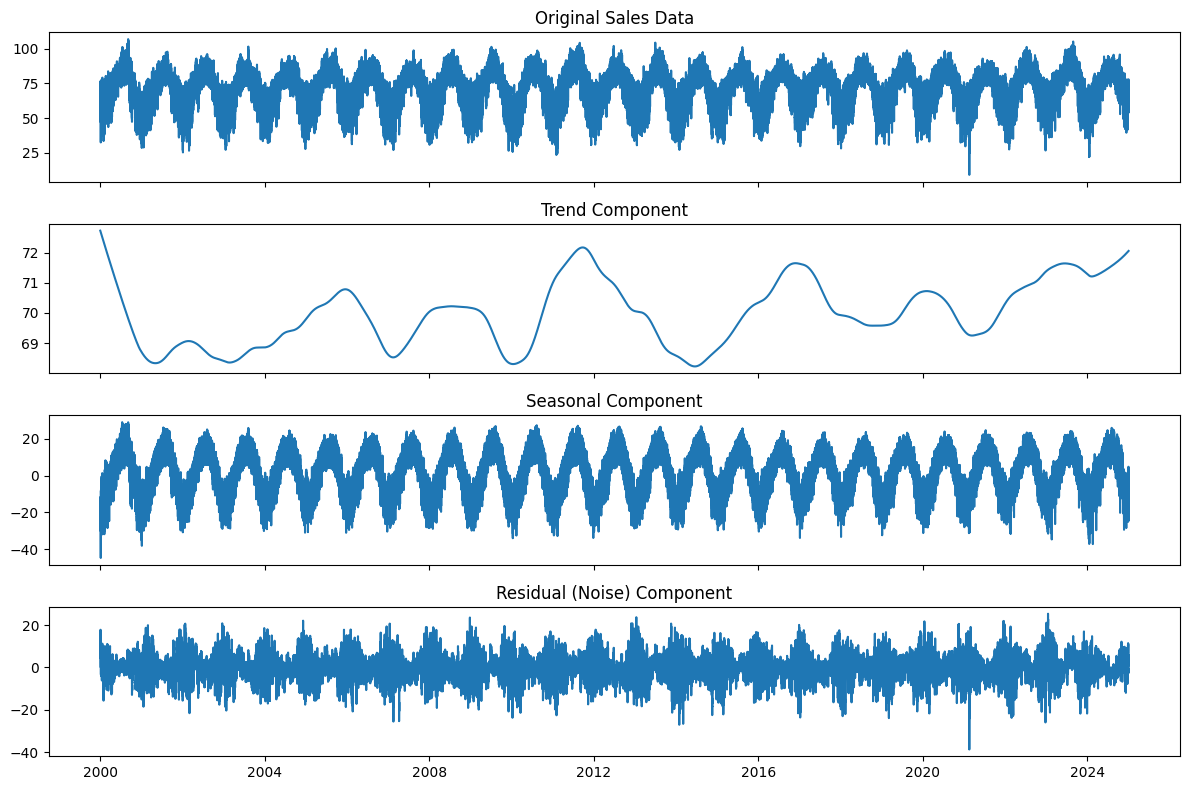

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
ax1.plot(clean_df['t2m (degF)'])
ax1.set_title('Original Sales Data')
ax2.plot(result.trend)
ax2.set_title('Trend Component')
ax3.plot(result.seasonal)
ax3.set_title('Seasonal Component')
ax4.plot(result.resid)
ax4.set_title('Residual (Noise) Component')
plt.tight_layout()
plt.show()

### Seasonality

We want to know if the time series is stationary across the entire dataset.

Augmented Dickey-Fuller (ADF) Test

Null Hypothesis: The time series has a unit root, indicating it is non-stationary.

Alternate Hypothesis: The time series does not have a unit root, indicating it is stationary.

Test Statistic: The ADF test statistic is compared to critical values from the ADF distribution to determine whether the null hypothesis can be rejected.

Decision Rule: If the test statistic is less than the critical value, the null hypothesis is rejected, and the series is considered stationary. Otherwise, if the test statistic is greater than the critical value, the null hypothesis is not rejected, and the series is considered non-stationary.

In [73]:
from statsmodels.tsa.stattools import adfuller

In [74]:
adf_results = adfuller(clean_df["t2m (degF)"].to_numpy())
print('ADF Statistic: %f' % adf_results[0])
print('p-value: %f' % adf_results[1])
print('Critical Values:')
for key, value in adf_results[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.657088
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


The p-value is very small (approximating to 0), indicating strong evidence against the null hypothesis. In this case, the null hypothesis is that the series has a unit root (i.e., it is non-stationary). The small p-value suggests that we can reject the null hypothesis and conclude that the detrended series is stationary.

The computed ADF statistic, indicating the strength of evidence against the null hypothesis of non-stationarity. Here, it is significantly negative, suggesting strong evidence in favor of stationarity.

### Trend

In [75]:
from sklearn.linear_model import LinearRegression	

In [76]:
X = np.arange(len(result.trend)).reshape(-1, 1)
y = result.trend
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

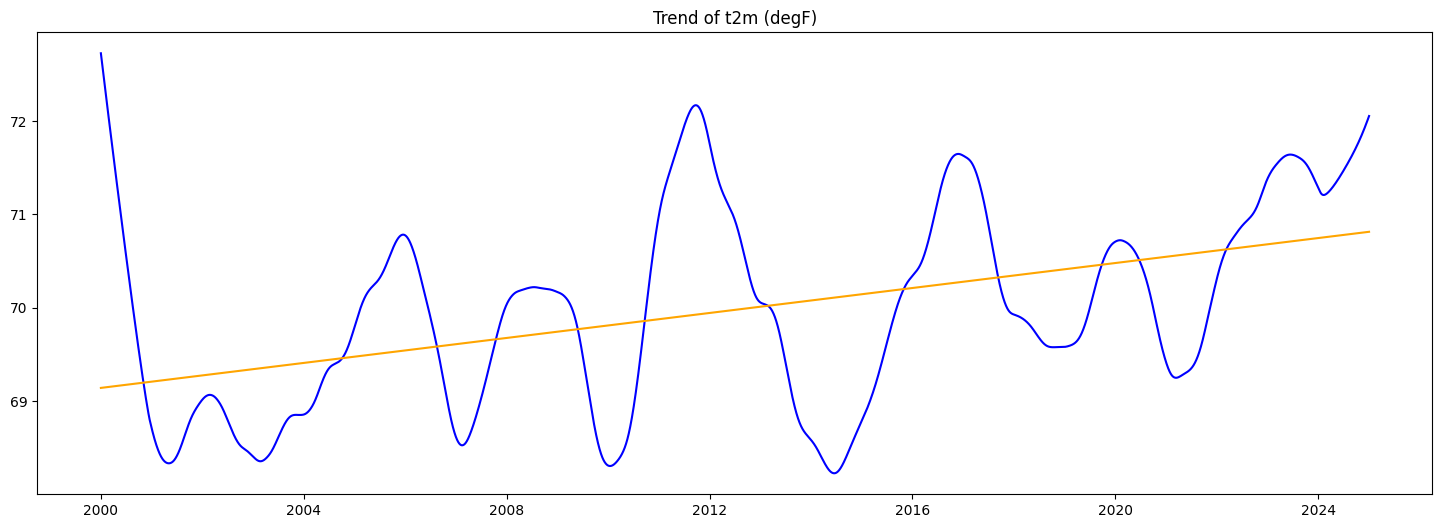

In [77]:
plt.figure(figsize=(18, 6))
plt.plot(clean_df.index, result.trend, color='blue')
plt.plot(clean_df.index, trend, color='orange')
plt.title('Trend of t2m (degF)')
plt.show()

We can choose to either remove the trend or add it as a feature to the dataset for prediction. If the trend was a feature, the trend would be difficult to obtain as the models are not continuously training on new data. We will go through with removing most of the trend. 

Unfortunately, removing the trends of each variable could result in bias as the variables are not fully independent from each other. There must be a way to find a common trend between the variables, but that will have to be something that can be done later.

## Model Tuning

Now that I covered some preprocessing methods, I can focus on optimizing the models that will be used for the project.

### Optimizing the LSTM model

I will be prioritizing these hyperparamters:

- loss function
- number of lstm nodes
- dropout %
- lstm layer activation function
- dense layer activation function
- learning rate

In [78]:
import keras
import keras_tuner as kt
from keras import layers

In [79]:
reduced_outlier_x_train.shape, reduced_outlier_y_train.shape

((58411, 32, 5), (58411, 1))

In [116]:
def build_lstm(hp):
    units = hp.Int("units", min_value=16, max_value=128, step=2, sampling="log") # [16, 32, 64, 128]
    activation = hp.Choice("activation", ["relu", "tanh"])
    dense_activation = hp.Choice("dense_activation", ["relu", "linear"])
    dropout = hp.Float("dropout", min_value=0, max_value=0.3, step=0.1) # [0.0, 0.1, 0.2, 0.3]
    lr = hp.Float("learning_rate", min_value=0.001, max_value=0.01, step=10, sampling="log") # [0.001, 0.01]

    X_shape = (58411, 32, 5)
    y_shape = (58411, 1)

    model = keras.Sequential()
    
    model.add(layers.Input(shape=(X_shape[1], X_shape[2])))
    model.add(layers.LSTM(units=units, dropout=dropout, activation=activation))
    model.add(layers.Dense(y_shape[1], activation=dense_activation))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [117]:
build_lstm(kt.HyperParameters())

<Sequential name=sequential_1, built=True>

In [ ]:
tuner = kt.Hyperband(hypermodel=build_lstm, objective="val_loss", max_epochs=20, seed=0)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [ ]:
tuner.search(x=reduced_outlier_x_train, y=reduced_outlier_y_train, epochs=20, batch_size=32, validation_data=(reduced_outlier_x_val, reduced_outlier_y_val), callbacks=[stop_early])

Trial 90 Complete [00h 02m 24s]
val_loss: 0.5805474519729614

Best val_loss So Far: 0.019892219454050064
Total elapsed time: 02h 57m 54s


In [121]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0046 summary
Hyperparameters:
units: 128
activation: tanh
dense_activation: linear
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0036
Score: 0.019892219454050064

Trial 0050 summary
Hyperparameters:
units: 128
activation: tanh
dense_activation: linear
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.019907696172595024

Trial 0047 summary
Hyperparameters:
units: 128
activation: relu
dense_activation: linear
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0035
Score: 0.020029818639159203

Trial 0051 summary
Hyperparameters:
units: 128
activation: relu
dense_activation: linear
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 50
tuner/init

In [126]:
best_lstm_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(f"Units: {best_lstm_hyperparameters.get('units')}")
print(f"Activation: {best_lstm_hyperparameters.get('activation')}")
print(f"Dense Activation: {best_lstm_hyperparameters.get('dense_activation')}")
print(f"Dropout: {best_lstm_hyperparameters.get('dropout')}")
print(f"Learning Rate: {best_lstm_hyperparameters.get('learning_rate')}")

# Train the best lstm model with the best hyperparameters
units = best_lstm_hyperparameters.get('units')
activation = best_lstm_hyperparameters.get('activation')
dense_activation = best_lstm_hyperparameters.get('dense_activation')
dropout = best_lstm_hyperparameters.get('dropout')
lr = best_lstm_hyperparameters.get('learning_rate')

X_shape = (58411, 32, 5)
y_shape = (58411, 1)

best_lstm_model = keras.Sequential()

best_lstm_model.add(layers.Input(shape=(X_shape[1], X_shape[2])))
best_lstm_model.add(layers.LSTM(units=units, dropout=dropout, activation=activation))
best_lstm_model.add(layers.Dense(y_shape[1], activation=dense_activation))
best_lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])


Best Hyperparameters:
Units: 128
Activation: tanh
Dense Activation: linear
Dropout: 0.0
Learning Rate: 0.001


In [127]:
history = best_lstm_model.fit(reduced_outlier_x_train, reduced_outlier_y_train, epochs=10, validation_data=(reduced_outlier_x_val, reduced_outlier_y_val), callbacks=[stop_early], verbose=1, batch_size=32)

Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.1035 - mean_absolute_error: 0.2232 - val_loss: 0.0311 - val_mean_absolute_error: 0.1254
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - loss: 0.0260 - mean_absolute_error: 0.1113 - val_loss: 0.0257 - val_mean_absolute_error: 0.1092
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - loss: 0.0234 - mean_absolute_error: 0.1053 - val_loss: 0.0244 - val_mean_absolute_error: 0.1052
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0221 - mean_absolute_error: 0.1023 - val_loss: 0.0249 - val_mean_absolute_error: 0.1055
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0214 - mean_absolute_error: 0.0994 - val_loss: 0.0238 - val_mean_absolute_error: 0.1028
Epoch 6/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - loss: 0.0200 - mean_absolute_error: 0.0970 - val_loss: 0.0240 - val_mean_absolute_error: 0.1051
Epoch 7/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.0198 - mea

In [128]:
y_hat = best_lstm_model.predict(reduced_outlier_x_test)

tuned_lstm_rmse = np.mean(((y_hat - reduced_outlier_y_test) ** 2))
print('RMSE of test set: ', tuned_lstm_rmse)

test_performance['Tuned LSTM'] = best_lstm_model.evaluate(reduced_outlier_x_test, reduced_outlier_y_test, return_dict=True)
print("Tuned LSTM test performance", test_performance["Tuned LSTM"])

descaled_tuned_y_hat = y_hat * reduced_outlier_train_std["t2m (degF)"] + reduced_outlier_train_mean["t2m (degF)"]
descaled_tuned_y_test = reduced_outlier_y_test * reduced_outlier_train_std["t2m (degF)"] + reduced_outlier_train_mean["t2m (degF)"]

228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
RMSE of test set:  0.017179532
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0173 - mean_absolute_error: 0.0889
Tuned LSTM test performance {'loss': 0.01717953570187092, 'mean_absolute_error': 0.09121721982955933}


In [156]:
best_lstm_model.save('houston_lstm_model.keras')
best_lstm_model.save('houston_lstm_model.keras')

In [157]:
best_lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,213 (805.52 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,476 (537.02 KB)

In [163]:
best_lstm_model.get_config()["layers"]

[{'module': 'keras.layers',
  'class_name': 'InputLayer',
  'config': {'batch_shape': (None, 32, 5),
   'dtype': 'float32',
   'sparse': False,
   'name': 'input_layer_2'},
  'registered_name': None},
 {'module': 'keras.layers',
  'class_name': 'LSTM',
  'config': {'name': 'lstm_2',
   'trainable': True,
   'dtype': 'float32',
   'return_sequences': False,
   'return_state': False,
   'go_backwards': False,
   'stateful': False,
   'unroll': False,
   'zero_output_for_mask': False,
   'units': 128,
   'activation': 'tanh',
   'recurrent_activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'module': 'keras.initializers',
    'class_name': 'GlorotUniform',
    'config': {'seed': None},
    'registered_name': None},
   'recurrent_initializer': {'module': 'keras.initializers',
    'class_name': 'OrthogonalInitializer',
    'config': {'gain': 1.0, 'seed': None},
    'registered_name': None},
   'bias_initializer': {'module': 'keras.initializers',
    'class_name': 'Zeros',

In [129]:
descaled_tuned_y_hat_df = pd.DataFrame(descaled_y_hat, columns=["t2m (degF)"])
descaled_tuned_y_hat_df["timestep"] = test_df.index[window:]
descaled_tuned_y_hat_df = descaled_tuned_y_hat_df.set_index("timestep")
descaled_tuned_y_test_df = pd.DataFrame(descaled_y_test, columns=["t2m (degF)"])
descaled_tuned_y_test_df["timestep"] = test_df.index[window:]
descaled_tuned_y_test_df = descaled_tuned_y_test_df.set_index("timestep")

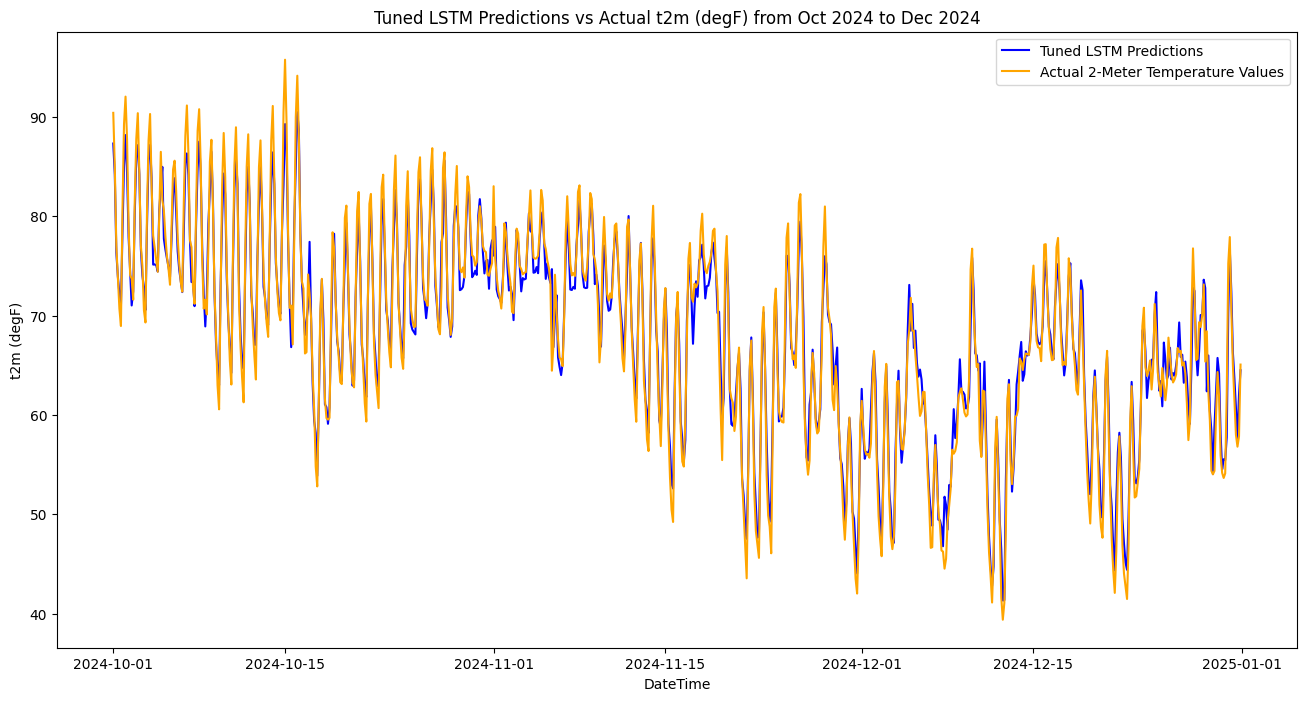

In [147]:
plt.figure(figsize=(16, 8))
plt.plot(test_df["2024-10-01 00:00:00":"2024-12-31 21:00:00"].index, descaled_tuned_y_hat_df["t2m (degF)"]["2024-10-01 00:00:00":"2024-12-31 21:00:00"], label='Tuned LSTM Predictions', color='blue')
plt.plot(test_df["2024-10-01 00:00:00":"2024-12-31 21:00:00"].index, descaled_y_test_df["t2m (degF)"]["2024-10-01 00:00:00":"2024-12-31 21:00:00"], label='Actual 2-Meter Temperature Values', color='orange')
plt.xlabel('DateTime')
plt.ylabel('t2m (degF)')
plt.title('Tuned LSTM Predictions vs Actual t2m (degF) from Oct 2024 to Dec 2024')
plt.legend()
plt.show()

### Increasing the window size

In [150]:
weekly_data_df = clean_df.copy()

In [202]:
train_len = int(np.ceil(weekly_data_df.shape[0]) * 0.8)
val_len = int(np.ceil(weekly_data_df.shape[0]) * 0.9)

train_df, val_df, test_df = weekly_data_df[:train_len], weekly_data_df[train_len:val_len], weekly_data_df[val_len:]

train_std = train_df.std()
train_mean = train_df.mean()

scaled_train_df = (train_df - train_mean) / train_std
scaled_val_df = (val_df - train_mean) / train_std
scaled_test_df = (test_df - train_mean) / train_std

lag_time = 56 # 7 days * 8 timesteps per day
lead_time = 1
window = lag_time + lead_time
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for i in range(scaled_train_df.shape[0]-window):
    x_train.append(scaled_train_df[i:i+lag_time])
    y_train.append(scaled_train_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_val_df.shape[0]-window):
    x_val.append(scaled_val_df[i:i+lag_time])
    y_val.append(scaled_val_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_test_df.shape[0]-window):
    x_test.append(scaled_test_df[i:i+lag_time])
    y_test.append(scaled_test_df[i+lag_time:i+window]["t2m (degF)"])

x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

In [203]:
x_train.shape, y_train.shape

((58387, 56, 5), (58387, 1))

In [204]:
best_lstm_model.get_config()["layers"][0]

{'module': 'keras.layers',
 'class_name': 'InputLayer',
 'config': {'batch_shape': (None, 32, 5),
  'dtype': 'float32',
  'sparse': False,
  'name': 'input_layer_2'},
 'registered_name': None}

In [205]:
best_lstm_model.get_config()["layers"][1]

{'module': 'keras.layers',
 'class_name': 'LSTM',
 'config': {'name': 'lstm_2',
  'trainable': True,
  'dtype': 'float32',
  'return_sequences': False,
  'return_state': False,
  'go_backwards': False,
  'stateful': False,
  'unroll': False,
  'zero_output_for_mask': False,
  'units': 128,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid',
  'use_bias': True,
  'kernel_initializer': {'module': 'keras.initializers',
   'class_name': 'GlorotUniform',
   'config': {'seed': None},
   'registered_name': None},
  'recurrent_initializer': {'module': 'keras.initializers',
   'class_name': 'OrthogonalInitializer',
   'config': {'gain': 1.0, 'seed': None},
   'registered_name': None},
  'bias_initializer': {'module': 'keras.initializers',
   'class_name': 'Zeros',
   'config': {},
   'registered_name': None},
  'unit_forget_bias': True,
  'kernel_regularizer': None,
  'recurrent_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,

In [206]:
best_lstm_model.get_config()["layers"][2]

{'module': 'keras.layers',
 'class_name': 'Dense',
 'config': {'name': 'dense_2',
  'trainable': True,
  'dtype': 'float32',
  'units': 1,
  'activation': 'linear',
  'use_bias': True,
  'kernel_initializer': {'module': 'keras.initializers',
   'class_name': 'GlorotUniform',
   'config': {'seed': None},
   'registered_name': None},
  'bias_initializer': {'module': 'keras.initializers',
   'class_name': 'Zeros',
   'config': {},
   'registered_name': None},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None},
 'registered_name': None,
 'build_config': {'input_shape': (None, 128)}}

In [207]:
units = 128
dropout = 0
activation = "tanh"
dense_activation = "linear"
lr = 0.001

lstm_model = keras.Sequential()
lstm_model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(layers.LSTM(units=units, dropout=dropout, activation=activation))
lstm_model.add(layers.Dense(y_train.shape[1], activation=dense_activation))
lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])

In [208]:
history = lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=1, batch_size=32)

Epoch 1/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - loss: 0.1118 - mean_absolute_error: 0.2291 - val_loss: 0.0282 - val_mean_absolute_error: 0.1129
Epoch 2/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - loss: 0.0256 - mean_absolute_error: 0.1100 - val_loss: 0.0254 - val_mean_absolute_error: 0.1049
Epoch 3/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 60s 33ms/step - loss: 0.0229 - mean_absolute_error: 0.1046 - val_loss: 0.0244 - val_mean_absolute_error: 0.1046


In [209]:
y_hat = lstm_model.predict(x_test)

rmse = np.mean(((y_hat - y_test) ** 2))
print('RMSE of test set: ', rmse)

test_performance['Weekly Lagged LSTM'] = lstm_model.evaluate(x_test, y_test, return_dict=True)
print("Weekly Lagged LSTM test performance", test_performance["Weekly Lagged LSTM"])

descaled_weekly_y_hat = y_hat * train_std["t2m (degF)"] + train_mean["t2m (degF)"]
descaled_weekly_y_test = y_test * train_std["t2m (degF)"] + train_mean["t2m (degF)"]

227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
RMSE of test set:  0.020571012
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0209 - mean_absolute_error: 0.0990
Weekly Lagged LSTM test performance {'loss': 0.020571015775203705, 'mean_absolute_error': 0.10091421008110046}


In [210]:
print(test_performance["Tuned LSTM"])
print(test_performance["Weekly Lagged LSTM"])

{'loss': 0.01717953570187092, 'mean_absolute_error': 0.09121721982955933}
{'loss': 0.020571015775203705, 'mean_absolute_error': 0.10091421008110046}


### Multi-Step LSMT model

In [237]:
train_len = int(np.ceil(weekly_data_df.shape[0]) * 0.8)
val_len = int(np.ceil(weekly_data_df.shape[0]) * 0.9)

train_df, val_df, test_df = weekly_data_df[:train_len], weekly_data_df[train_len:val_len], weekly_data_df[val_len:]

train_std = train_df.std()
train_mean = train_df.mean()

scaled_train_df = (train_df - train_mean) / train_std
scaled_val_df = (val_df - train_mean) / train_std
scaled_test_df = (test_df - train_mean) / train_std

lag_time = 56 # 7 days * 8 timesteps per day
lead_time = 2 # predict the next 6 hours
window = lag_time + lead_time
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for i in range(scaled_train_df.shape[0]-window):
    x_train.append(scaled_train_df[i:i+lag_time])
    y_train.append(scaled_train_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_val_df.shape[0]-window):
    x_val.append(scaled_val_df[i:i+lag_time])
    y_val.append(scaled_val_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_test_df.shape[0]-window):
    x_test.append(scaled_test_df[i:i+lag_time])
    y_test.append(scaled_test_df[i+lag_time:i+window]["t2m (degF)"])

x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

In [238]:
x_train.shape, y_train.shape

((58386, 56, 5), (58386, 2))

In [239]:
units = 128
dropout = 0
activation = "tanh"
dense_activation = "linear"
lr = 0.001

multi_step_lstm_model = keras.Sequential()
multi_step_lstm_model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))
multi_step_lstm_model.add(layers.LSTM(units=units, dropout=dropout, activation=activation))
multi_step_lstm_model.add(layers.Dense(y_train.shape[1], activation=dense_activation))
multi_step_lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])

In [240]:
history = multi_step_lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=1, batch_size=32)

Epoch 1/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - loss: 0.1195 - mean_absolute_error: 0.2451 - val_loss: 0.0420 - val_mean_absolute_error: 0.1384
Epoch 2/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - loss: 0.0374 - mean_absolute_error: 0.1332 - val_loss: 0.0381 - val_mean_absolute_error: 0.1313
Epoch 3/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - loss: 0.0337 - mean_absolute_error: 0.1266 - val_loss: 0.0361 - val_mean_absolute_error: 0.1293


In [241]:
multi_step_lstm_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,600 (807.04 KB)

 Trainable params: 68,866 (269.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,734 (538.03 KB)

In [242]:
y_hat = multi_step_lstm_model.predict(x_test)

rmse = np.mean(((y_hat - y_test) ** 2))
print('RMSE of test set: ', rmse)

test_performance['6H Forecast LSTM'] = multi_step_lstm_model.evaluate(x_test, y_test, return_dict=True)
print("6H Forecast LSTM test performance", test_performance["6H Forecast LSTM"])

descaled_weekly_y_hat = y_hat * train_std["t2m (degF)"] + train_mean["t2m (degF)"]
descaled_weekly_y_test = y_test * train_std["t2m (degF)"] + train_mean["t2m (degF)"]

227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
RMSE of test set:  0.031016866
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0312 - mean_absolute_error: 0.1228
6H Forecast LSTM test performance {'loss': 0.031016862019896507, 'mean_absolute_error': 0.12454254180192947}


In [243]:
print(test_performance["Tuned LSTM"])
print(test_performance["Weekly Lagged LSTM"])
print(test_performance["6H Forecast LSTM"])

{'loss': 0.01717953570187092, 'mean_absolute_error': 0.09121721982955933}
{'loss': 0.020571015775203705, 'mean_absolute_error': 0.10091421008110046}
{'loss': 0.031016862019896507, 'mean_absolute_error': 0.12454254180192947}


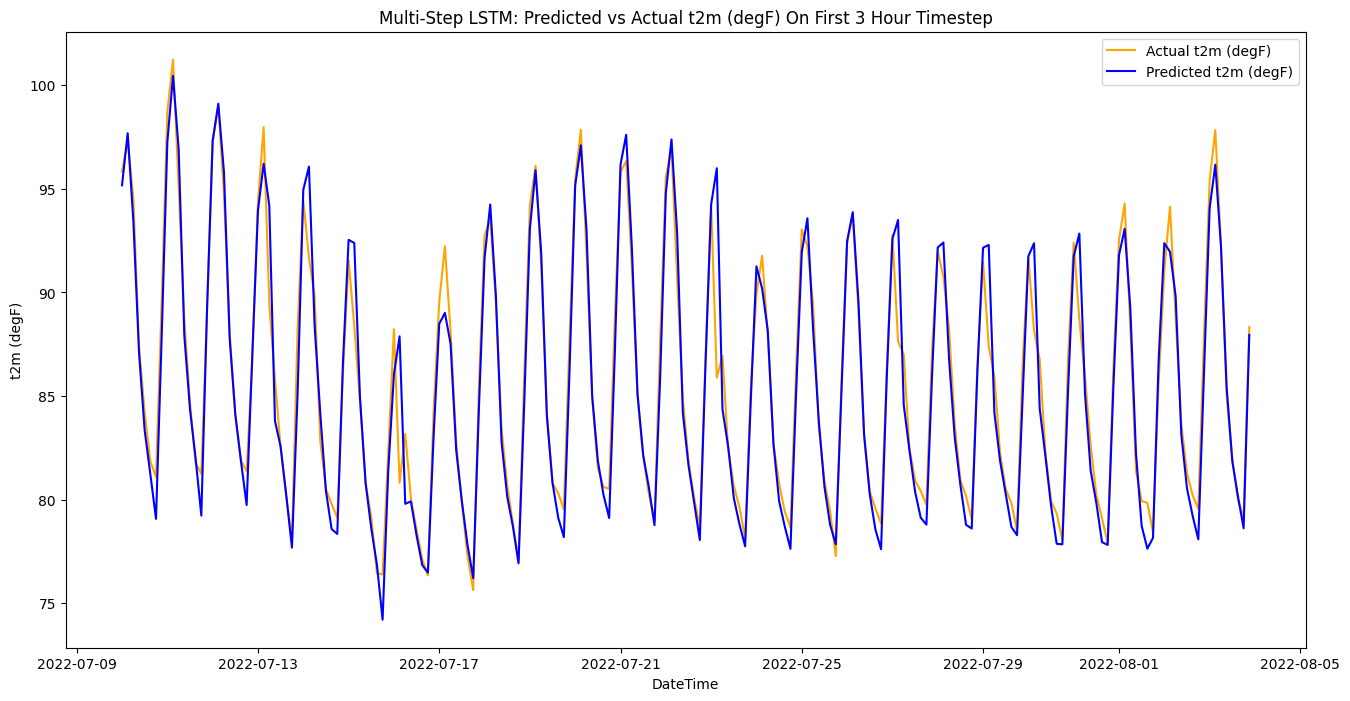

In [244]:
plt.figure(figsize=(16, 8))
# Plot the first 200 time steps for clarity
timesteps = 200
plt.plot(
	test_df.index[window:window+timesteps],
	descaled_weekly_y_test[:timesteps, 0],
	label="Actual t2m (degF)", color="orange"
)
plt.plot(
	test_df.index[window:window+timesteps],
	descaled_weekly_y_hat[:timesteps, 0],
	label="Predicted t2m (degF)", color="blue"
)
plt.xlabel("DateTime")
plt.ylabel("t2m (degF)")
plt.title("Multi-Step LSTM: Predicted vs Actual t2m (degF) On First 3 Hour Timestep")
plt.legend()
plt.show()

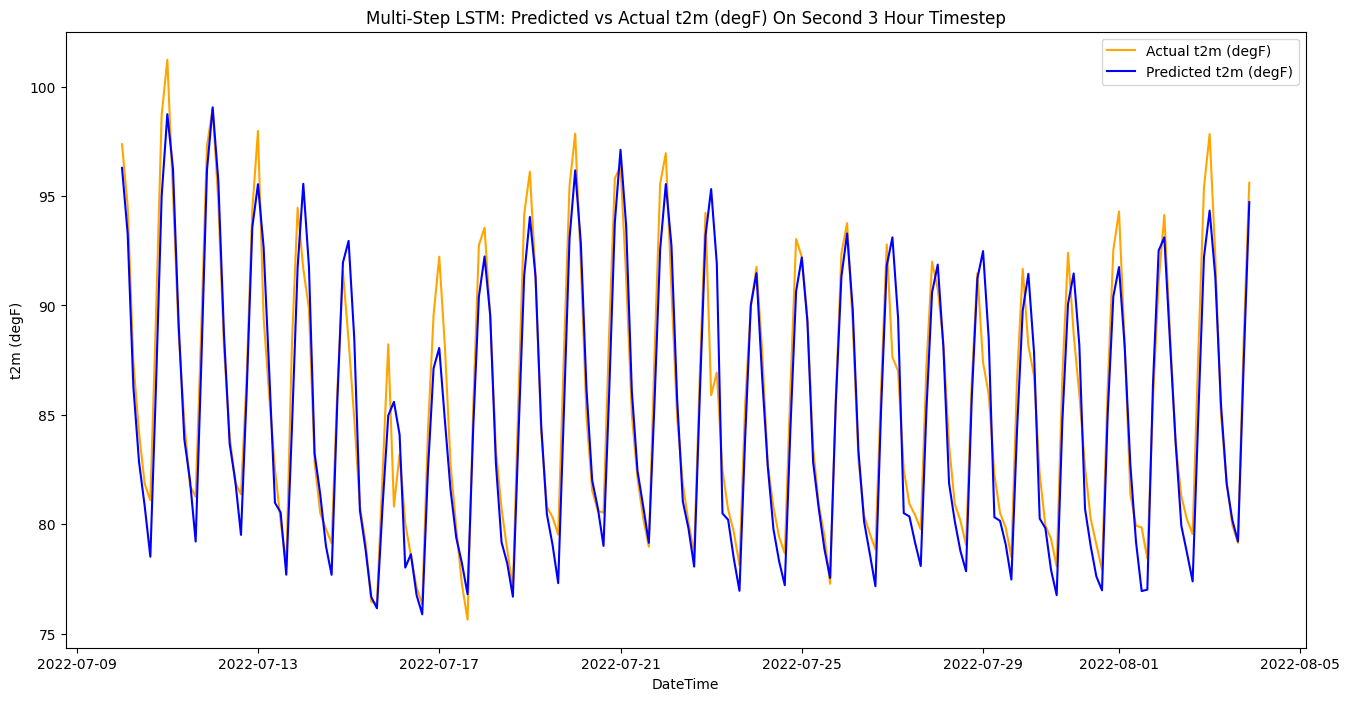

In [245]:
plt.figure(figsize=(16, 8))
# Plot the first 200 time steps for clarity
timesteps = 200
plt.plot(
	test_df.index[window:window+timesteps],
	descaled_weekly_y_test[:timesteps, 1],
	label="Actual t2m (degF)", color="orange"
)
plt.plot(
	test_df.index[window:window+timesteps],
	descaled_weekly_y_hat[:timesteps, 1],
	label="Predicted t2m (degF)", color="blue"
)
plt.xlabel("DateTime")
plt.ylabel("t2m (degF)")
plt.title("Multi-Step LSTM: Predicted vs Actual t2m (degF) On Second 3 Hour Timestep")
plt.legend()
plt.show()

### Creating a 1D CNN model

In [ ]:
layer_1_filters = 64
layer_2_filters = 64
kernel_size = 2

cnn_model = keras.Sequential()

# 1D CNN input shape is (batch_shape, steps, features)

cnn_model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2]), batch_size=32))
cnn_model.add(layers.Conv1D(filters=layer_1_filters, kernel_size=kernel_size, activation="relu"))
cnn_model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="valid"))
cnn_model.add(layers.Conv1D(filters=layer_2_filters, kernel_size=kernel_size, activation="relu"))
cnn_model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="valid"))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units=y_train.shape[1], activation="linear"))

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])

In [277]:
cnn_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (32, 55, 64)           │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (32, 27, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (32, 26, 64)           │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (32, 13, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 832)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (32, 2)                │         1,666 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,626 (41.51 KB)

 Trainable params: 10,626 (41.51 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
history = cnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=1, batch_size=32)

Epoch 1/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1442 - mean_absolute_error: 0.2692 - val_loss: 0.0784 - val_mean_absolute_error: 0.2014
Epoch 2/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0670 - mean_absolute_error: 0.1857 - val_loss: 0.0688 - val_mean_absolute_error: 0.1864
Epoch 3/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0609 - mean_absolute_error: 0.1757 - val_loss: 0.0666 - val_mean_absolute_error: 0.1809


In [279]:
y_hat = cnn_model.predict(x_test)

rmse = np.mean(((y_hat - y_test) ** 2))
print('RMSE of test set: ', rmse)

test_performance['CNN'] = cnn_model.evaluate(x_test, y_test, return_dict=True)
print("CNN test performance", test_performance["CNN"])

descaled_y_hat = y_hat * train_std["t2m (degF)"] + train_mean["t2m (degF)"]
descaled_y_test = y_test * train_std["t2m (degF)"] + train_mean["t2m (degF)"]

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE of test set:  0.056935064
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562 - mean_absolute_error: 0.1668
CNN test performance {'loss': 0.056935057044029236, 'mean_absolute_error': 0.1709769368171692}


In [284]:
cnn_train_len = int(np.ceil(weekly_data_df.shape[0]) * 0.8)
cnn_val_len = int(np.ceil(weekly_data_df.shape[0]) * 0.9)

cnn_train_df, cnn_val_df, cnn_test_df = weekly_data_df[:cnn_train_len], weekly_data_df[cnn_train_len:cnn_val_len], weekly_data_df[cnn_val_len:]

train_std = cnn_train_df.std()
train_mean = cnn_train_df.mean()

scaled_train_df = (cnn_train_df - train_mean) / train_std
scaled_val_df = (cnn_val_df - train_mean) / train_std
scaled_test_df = (cnn_test_df - train_mean) / train_std

# Use last week's data to predict 3 hours ahead
lag_time = 56 # 7 days * 8 timesteps 
lead_time = 1
window = lag_time + lead_time
cnn_x_train = []
cnn_y_train = []
cnn_x_val = []
cnn_y_val = []
cnn_x_test = []
cnn_y_test = []

for i in range(scaled_train_df.shape[0]-window):
    cnn_x_train.append(scaled_train_df[i:i+lag_time])
    cnn_y_train.append(scaled_train_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_val_df.shape[0]-window):
    cnn_x_val.append(scaled_val_df[i:i+lag_time])
    cnn_y_val.append(scaled_val_df[i+lag_time:i+window]["t2m (degF)"])

for i in range(scaled_test_df.shape[0]-window):
    cnn_x_test.append(scaled_test_df[i:i+lag_time])
    cnn_y_test.append(scaled_test_df[i+lag_time:i+window]["t2m (degF)"])

cnn_x_train, cnn_y_train = np.array(cnn_x_train), np.array(cnn_y_train)
cnn_x_val, cnn_y_val = np.array(cnn_x_val), np.array(cnn_y_val)
cnn_x_test, cnn_y_test = np.array(cnn_x_test), np.array(cnn_y_test)

### Tuning the 1D CNN model

In [ ]:
def build_cnn(hp):
    repeat_conv1d_maxPool1d = hp.Int("Repeat Convolution and Pooling layers", min_value=1, max_value=2, step=1) # [1, 2]
    filters = hp.Int("Filters", min_value=64, max_value=128, step=2, sampling="log") # [56, 64, 128]
    filters_sampling = hp.Choice("Same, Increase, or Decrease Filters", ["same", "increase", "decrease"])
    kernel_size = hp.Int("Kernel Size", min_value=2, max_value=4, step=1) # [2, 3, 4]
    max_pool_size = hp.Int("Pool Size", min_value=2, max_value=4, step=1) # [2, 3, 4]
    include_batch_normalization = hp.Choice("Include Batch Normalization", ["no", "yes"])
    include_dense_layer = hp.Choice("Include First Dense Layer", ["no", "yes"])
    layer_1_dense_units = hp.Int("Layer 1 Dense Units", min_value=32, max_value=64, step=2, sampling="log") # [32, 64]

    X_shape = (58411, 56, 5)
    y_shape = (58411, 1)

    cnn_model = keras.Sequential()
    cnn_model.add(layers.Input(shape=(X_shape[1], X_shape[2]), batch_size=32))
    
    initial_filters = filters
    layer_x_filters = 64
    for i in range(1, repeat_conv1d_maxPool1d + 1):

        if filters_sampling == "same":
            layer_x_filters = initial_filters
        if filters_sampling == "increase":
            layer_x_filters *= 2
        if filters_sampling == "decrease":
            layer_x_filters /= 2

        if include_batch_normalization == "yes":
            cnn_model.add(layers.Conv1D(filters=layer_x_filters, kernel_size=kernel_size, activation="relu"))
            cnn_model.add(layers.MaxPool1D(pool_size=max_pool_size, padding="valid"))
            cnn_model.add(layers.BatchNormalization())
        else:
            cnn_model.add(layers.Conv1D(filters=layer_x_filters, kernel_size=kernel_size, activation="relu"))
            cnn_model.add(layers.MaxPool1D(pool_size=max_pool_size, padding="valid"))

    cnn_model.add(layers.Flatten())
    
    if include_dense_layer == "yes":
        cnn_model.add(layers.Dense(units=layer_1_dense_units, dense_activation="relu"))

    cnn_model.add(layers.Dense(units=y_shape[1]))

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])
    
    return cnn_model

In [292]:
build_cnn(kt.HyperParameters())

<Sequential name=sequential_25, built=True>

In [293]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')

In [294]:
cnn_tuner = kt.Hyperband(hypermodel=build_cnn, objective="val_loss", max_epochs=12, seed=0)
cnn_tuner.search(x=cnn_x_train, y=cnn_y_train, epochs=12, batch_size=32, validation_data=(cnn_x_val, cnn_y_val), callbacks=[stop_early])

Trial 22 Complete [00h 01m 23s]
val_loss: 0.053813714534044266

Best val_loss So Far: 0.038850389420986176
Total elapsed time: 00h 11m 29s


In [295]:
cnn_tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0005 summary
Hyperparameters:
Repeat Convolution and Pooling layers: 1
Filters: 64
Same, Increase, or Decrease Filters: same
Kernel Size: 3
Pool Size: 2
Include Batch Normalization: no
Dense Layer Activation: linear
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.038850389420986176

Trial 0021 summary
Hyperparameters:
Repeat Convolution and Pooling layers: 1
Filters: 64
Same, Increase, or Decrease Filters: same
Kernel Size: 4
Pool Size: 2
Include Batch Normalization: yes
Dense Layer Activation: linear
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.053813714534044266

Trial 0019 summary
Hyperparameters:
Repeat Convolution and Pooling layers: 1
Filters: 128
Same, Increase, or Decrease Filters: same
Kernel Size: 4
Pool Size: 4
Include Batch Normalization: yes
Dense Layer Activation: linear
tuner/epochs: 12

In [296]:
best_cnn_hyperparameters = cnn_tuner.get_best_hyperparameters()[0]
print(best_cnn_hyperparameters)

In [297]:
print("Best Hyperparameters:")
print(f"Repeat Convolution and Pooling layers: {best_cnn_hyperparameters.get('Repeat Convolution and Pooling layers')}")
print(f"Filters: {best_cnn_hyperparameters.get('Filters')}")
print(f"Same, Increase, or Decrease Filters: {best_cnn_hyperparameters.get('Same, Increase, or Decrease Filters')}")
print(f"Kernel Size: {best_cnn_hyperparameters.get('Kernel Size')}")
print(f"Pool Size: {best_cnn_hyperparameters.get('Pool Size')}")
print(f"Include Batch Normalization: {best_cnn_hyperparameters.get('Include Batch Normalization')}")
print(f"Dense Layer Activation: {best_cnn_hyperparameters.get('Dense Layer Activation')}")

Best Hyperparameters:
Repeat Convolution and Pooling layers: 1
Filters: 64
Same, Increase, or Decrease Filters: same
Kernel Size: 3
Pool Size: 2
Include Batch Normalization: no
Dense Layer Activation: linear


In [298]:
repeat_conv1d_maxPool1d = best_cnn_hyperparameters.get('Repeat Convolution and Pooling layers')
filters = best_cnn_hyperparameters.get('Filters')
filters_sampling = best_cnn_hyperparameters.get('Same, Increase, or Decrease Filters')
kernel_size = best_cnn_hyperparameters.get('Kernel Size')
max_pool_size = best_cnn_hyperparameters.get('Pool Size')
batch_normalization = best_cnn_hyperparameters.get('Include Batch Normalization')
dense_activation = best_cnn_hyperparameters.get('Dense Layer Activation')

In [299]:
# X_shape = (58411, 32, 5)
# y_shape = (58411, 1)

# best_cnn_model = keras.Sequential()

# best_cnn_model.add(layers.Input(shape=(X_shape[1], X_shape[2])))
# best_cnn_model.add(layers.cnn(units=units, dropout=dropout, activation=activation))
# best_cnn_model.add(layers.Dense(y_shape[1], activation=dense_activation))
# best_cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()])